## Final Project Submission

# Problem Statement

Azulejos Ltd. is a boutique hotel management company that has two properties in Portugal. These two properties had 119,390 reservations made between July 1, 2015 and August 13, 2017. Of these reservations, 44,224 (37%) canceled before their scheduled arrival date.

## Business Value

On average, customers reserve a room 104 days before their anticipated arrival date. Once it is reserved, it is unavailable to other customers. As a result, cancellations can result in reduced profits if the room is unable to be re-booked before the scheduled dates. With an average daily rate of  €101.83 and an average stay length of 3.4 days, a canceled room that remains vacant costs the hotel an average of €346.22.

Currently, only 12.2% of the customers are charged a non-refundable deposit, which helps to mitigate the profit loss caused by cancellations. That leaves a significant number of reservations that carry a risk of profit loss.

By identifying ahead of time which customers are more likely to cancel and understanding the patterns that occur in cancellations, the Azulejos Ltd. will be able to implement strategies to reduce the lost profits that result from cancellations.

## Questions to Consider

- How can we predict the customers that are most likely to cancel their reservations?
- How do cancellations vary based on other factors (time, customer-location, etc.)?
- What strategies can be implemented to mitigate the impact of cancellations on profit?

## Methodology

The data from 119,390 reservations made between July 1, 2015 and August 13, 2017 will be used to create a model that can use information about a customer and their reservation to predict if they are likely to cancel. In addition, the data will be analyzed for trends and patterns that will help to understand when and why cancellations occur. 

# Obtain the Data

In [280]:
# import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (VotingClassifier, 
                              RandomForestClassifier, 
                              AdaBoostClassifier, 
                              GradientBoostingClassifier, 
                              AdaBoostClassifier,
                              BaggingClassifier
                             )
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import ClusterCentroids
from sklearn.metrics import (accuracy_score, 
                             f1_score, 
                             recall_score, 
                             precision_score,
                             precision_recall_curve,
                             make_scorer, 
                             plot_confusion_matrix,
                             plot_roc_curve,
                             classification_report
)


import joblib
import xgboost as xgb
from xgboost import plot_importance

%matplotlib inline

In [2]:
#Create global variables for colors.
NEUTRAL = '#4e6e9a'
POS = '#87c5ae'
NEG = "#ffc92f"
COLORS = [NEUTRAL, NEG, POS]
sns.set_palette(COLORS)

#Global variable for random state.
SEED = 85

#Global variable for class names.
CLASS_NAMES = ['not_canceled','canceled']

In [3]:
hotels = pd.read_csv('hotel_booking.csv',parse_dates= (
    {"arrival_date" : [
        "arrival_date_year",
        "arrival_date_month",
        "arrival_date_day_of_month"]}))
hotels.head()

,arrival_date,hotel,is_canceled,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
0,2015-07-01,Resort Hotel,0,342,27,0,0,2,0.0,0,...,Transient,0.0,0,0,Check-Out,2015-07-01,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322
1,2015-07-01,Resort Hotel,0,737,27,0,0,2,0.0,0,...,Transient,0.0,0,0,Check-Out,2015-07-01,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157
2,2015-07-01,Resort Hotel,0,7,27,0,1,1,0.0,0,...,Transient,75.0,0,0,Check-Out,2015-07-02,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734
3,2015-07-01,Resort Hotel,0,13,27,0,1,1,0.0,0,...,Transient,75.0,0,0,Check-Out,2015-07-02,Laura Murray,Laura_M@gmail.com,364-656-8427,************5677
4,2015-07-01,Resort Hotel,0,14,27,0,2,2,0.0,0,...,Transient,98.0,0,1,Check-Out,2015-07-03,Linda Hines,LHines@verizon.com,713-226-5883,************5498


## Initial Exploration

The data consist of 119,390 observations from either a city or resort hotel in Portugal from July 1015 to August 2017. 

In [4]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 34 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   arrival_date                    119390 non-null  datetime64[ns]
 1   hotel                           119390 non-null  object        
 2   is_canceled                     119390 non-null  int64         
 3   lead_time                       119390 non-null  int64         
 4   arrival_date_week_number        119390 non-null  int64         
 5   stays_in_weekend_nights         119390 non-null  int64         
 6   stays_in_week_nights            119390 non-null  int64         
 7   adults                          119390 non-null  int64         
 8   children                        119386 non-null  float64       
 9   babies                          119390 non-null  int64         
 10  meal                            119390 non-null  object 

There are missing values that will need to be addressed, synthetic data (name, email, phone and credit card) that will need to be dropped and the date-related columns will need to be transformed into datetime objects so that the time of the cancellation relative to the reservation data can be calculated. 

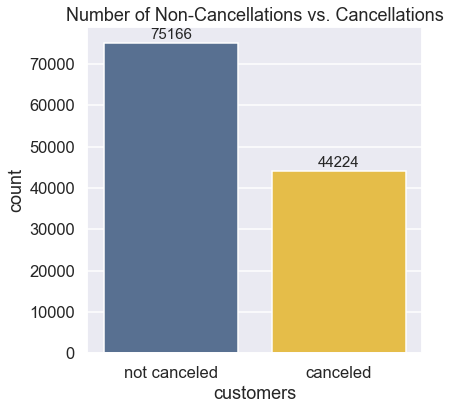

In [5]:
class_balance = hotels['is_canceled'].value_counts().reset_index()

sns.set_style('darkgrid')
sns.set_context('talk')
fig,ax=plt.subplots(figsize=(6,6))
values = np.array(class_balance['is_canceled']) 
clr = [NEUTRAL if x>44224 else NEG for x in values]
plots = sns.barplot(data = class_balance, 
                    x='index',
                    y='is_canceled',
                    palette=clr)
ax.set_xticklabels(['not canceled','canceled'])
ax.set_xlabel('customers')
ax.set_ylabel('count')
ax.set_title('Number of Non-Cancellations vs. Cancellations')
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.0f'),
                       (bar.get_x() + bar.get_width() / 2,
                        bar.get_height()), ha='center', va='center',
                       size=15, xytext=(0, 8),
                       textcoords='offset points')

There is a class imbalance, with 63% belonging to the negative class (not canceled) and 37% belonging to the positive class (canceled). This imbalance will need to be addressed before any modeling. 

# Data Processing

## Feature Engineering

In [6]:
hotels_engineered = hotels.copy()
hotels_engineered.shape

(119390, 34)

### Reservation Status Date

In [7]:
#Check how many customers canceled their reservation on the same day they 
#made it.
canceled = hotels_engineered[hotels_engineered['is_canceled'] == 1]
canceled[canceled['lead_time'] == 0].shape

(430, 34)

Because these customers did not have a room reserved for any real period of time, their cancellations did not impact the profitability of the hotel. I am going to remove these records from the data.

In [8]:
index_names = hotels_engineered[(hotels_engineered['is_canceled']==1)&(hotels_engineered['lead_time']==0)].index
hotels_engineered = hotels_engineered.drop(index_names)
hotels_engineered.shape

(118960, 34)

In [9]:
# Change from string to datetime object so that it can be compared with
#arrival date.
hotels_engineered['reservation_status_date'] = pd.to_datetime(
    hotels_engineered['reservation_status_date'])

### Hotel

In [10]:
# Replace the hotel column with city_hotel where 1=city, 0=resort. 
hotels_engineered['city_hotel'] = np.where(
    hotels_engineered['hotel'] == 'City Hotel', 1, 0)
hotels_engineered = hotels_engineered.drop('hotel', axis=1)

### Lead Time

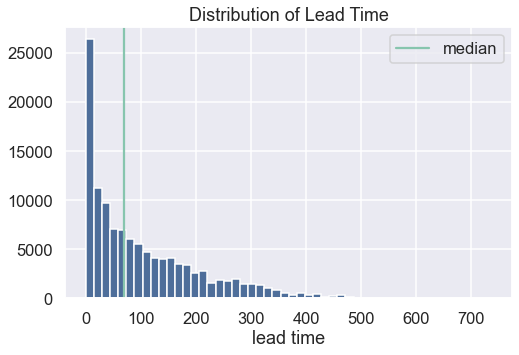

In [11]:
#Examine the distribution of lead time
fig, ax = plt.subplots(figsize=(8,5))
hotels_engineered['lead_time'].hist(bins=50, color=NEUTRAL)
plt.title('Distribution of Lead Time')
ax.set_xlabel('lead time')
plt.axvline(hotels_engineered['lead_time'].quantile(0.5), color=POS, label='median')
plt.legend();

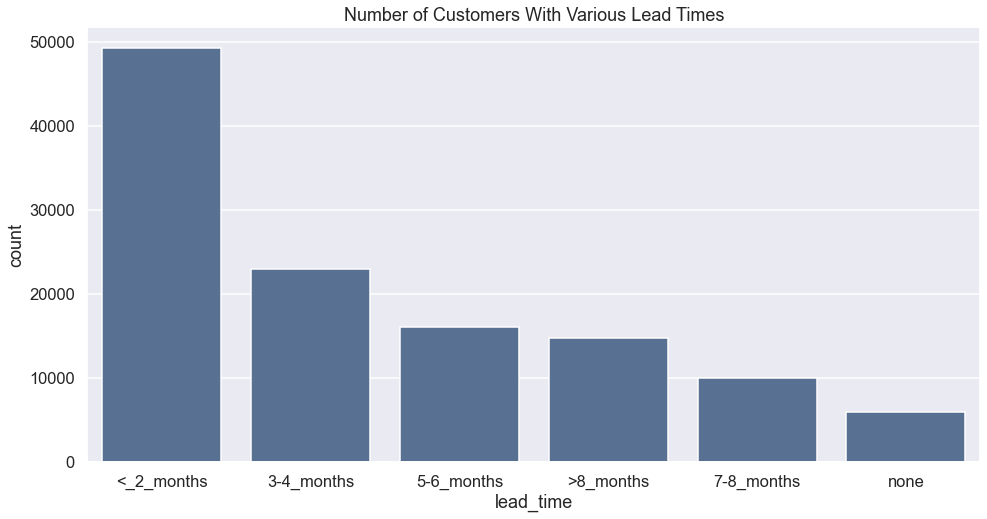

In [12]:
#Because the data is skewed and many of the same values repeat (especially 
#with low lead times), I am going to bin this data into 6 groups to start 
#with.

def lead_time_groups(lead_time):
    if lead_time == 0:
        return 'none'
    elif lead_time <= 60:
        return '<_2_months'
    elif lead_time <= 120:
        return '3-4_months'
    elif lead_time <= 180:
        return '5-6_months'
    elif lead_time <= 240:
        return '7-8_months'
    else:
        return '>8_months'
    
hotels_engineered['lead_time'] = (
    hotels_engineered['lead_time'].apply(lead_time_groups))

lead_times = hotels_engineered['lead_time'].value_counts().reset_index()
lead_times.columns = ['lead_time','count']
fig,ax = plt.subplots(figsize=(16,8))
sns.barplot(data=lead_times, x='lead_time',y='count', color=NEUTRAL)
plt.title('Number of Customers With Various Lead Times');

### Stay Length

In [13]:
#I am going to combine the weekend and weeknight columns to create a total
#length of stay column.
hotels_engineered['stay_length'] = (
    hotels_engineered['stays_in_weekend_nights'] +
    hotels_engineered['stays_in_week_nights']
)
hotels_engineered = hotels_engineered.drop(['stays_in_weekend_nights',
                                            'stays_in_week_nights'],axis=1)

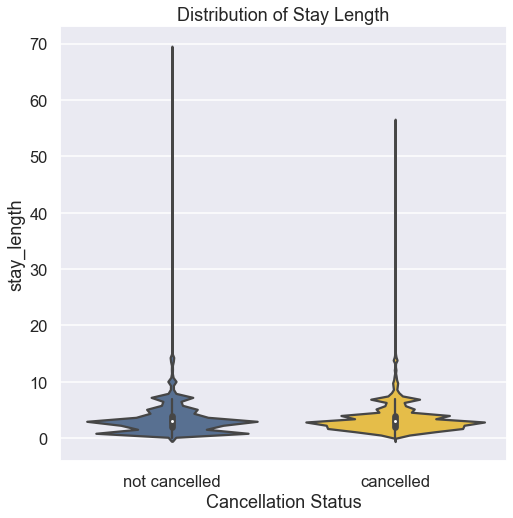

In [14]:
#Examine the distribution of stay length by cancellation status.
fig, ax = plt.subplots(figsize=(8,8))
sns.violinplot(data=hotels_engineered, x='is_canceled',y='stay_length')
plt.xlabel('Cancellation Status')
ax.set_xticklabels(['not cancelled', 'cancelled'])
plt.title('Distribution of Stay Length');

In [15]:
#Check to see the cancellation status of those with 0-night stays.
zero_stay = hotels_engineered[hotels_engineered['stay_length']==0]
zero_stay['is_canceled'].value_counts()

0    680
1     19
Name: is_canceled, dtype: int64

In [16]:
#Check the average daily rate for 0-night stays.
zero_stay['adr'].value_counts()

0.0    699
Name: adr, dtype: int64

Interestingly, there are 680 observations that indicate that a customer checked in and checked out, but had a total stay of 0 nights. This is confirmed by examining the records and noting that in these cases, the reservation date matches the reservation status date, which for customers who did not cancel, is the day they checked out. In looking at the average daily rate for these customers, it is clear that they did not pay for the room, even if they did not technically cancel. 

In [17]:
#Check the count of how many 0-night customers either cancelled their 
#reservation or "checked out" on the day of the reservation.
zero_stay[(
    zero_stay['arrival_date'] == 
    zero_stay['reservation_status_date'])].shape

(699, 33)

Often further examination, none of these customers reserved the room ahead of time. This means that although they did not contribute to any profit for the hotel, they also did not prevent the hotel from earning profit because the room was not held in reserve for them. It is unclear why some of these are coded as cancellations and others are recorded as checked-out. Because this data is ambiguous and the last-minute reservations did not hinder profitability, I am going to drop these records from the data.

In [18]:
hotels_engineered = hotels_engineered[hotels_engineered['stay_length'] != 0]
hotels_engineered.shape

(118261, 33)

For now, I am going to leave stay length as-is, although I may group it into categories later.

### Number of People

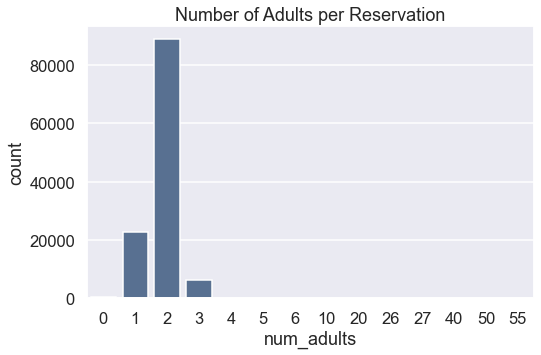

In [19]:
adult_counts = hotels_engineered['adults'].value_counts().reset_index()
adult_counts.columns = ['num_adults', 'count']
fig,ax = plt.subplots(figsize=(8,5))
sns.barplot(data=adult_counts, x='num_adults',y='count', color=NEUTRAL)
plt.title('Number of Adults per Reservation');

Most reservations have either 1 or 2 adults, with some having up to 55. I am going to change this column to be categorical with the following string values: 0, 1, 2, 3+. It is unclear if the records with 0 adults are data entry errors or reservations for public areas, such as conference rooms.

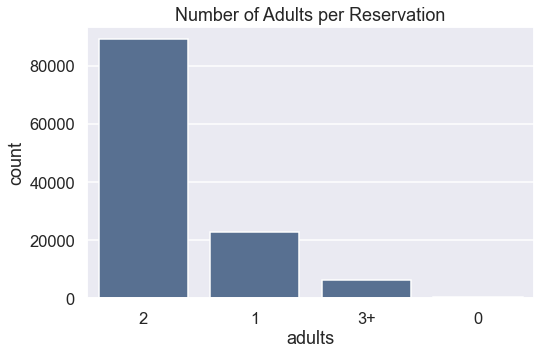

In [20]:
def num_adults(adults):
    if adults >= 3:
        return '3+'
    else:
        return str(adults)

hotels_engineered['adults'] = hotels_engineered['adults'].apply(num_adults)
adults = hotels_engineered['adults'].value_counts().reset_index()
adults.columns = ['adults', 'count']
fig,ax = plt.subplots(figsize=(8,5))
sns.barplot(data=adults, x='adults',y='count', color=NEUTRAL)
plt.title('Number of Adults per Reservation');

Currently, children and babies are listed separately and it appears that there may be some data entry errors (10 babies). I am going to combine these into a new columns, has_children, with 1 for having at least one non-adult on the reservation and 0 otherwise. 

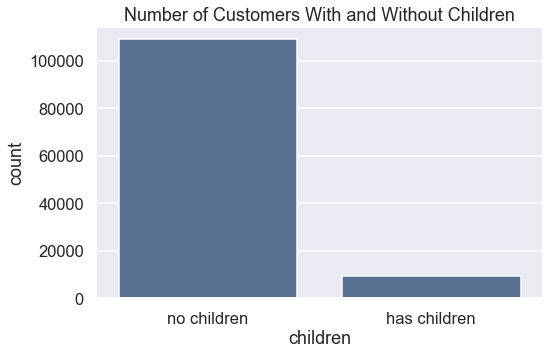

In [21]:
hotels_engineered['has_children'] = (hotels_engineered['children'] + 
                                     hotels_engineered['babies'])

hotels_engineered['has_children'] =np.where(
    hotels_engineered['has_children'] >0, 1, 0)

hotels_engineered = hotels_engineered.drop(['children','babies'], axis=1)

children = hotels_engineered['has_children'].value_counts().reset_index()
children.columns=['children', 'count']
fig,ax = plt.subplots(figsize=(8,5))
sns.barplot(data=children, x='children',y='count', color=NEUTRAL)
plt.title('Number of Customers With and Without Children')
ax.set_xticklabels(['no children','has children']);


Clearly, the majority of the customers are traveling without children. 

### Country

In [22]:
hotels_engineered['country'].nunique()

177

In [23]:
hotels_engineered['country'].value_counts(normalize=True)[:10]

PRT    0.404535
GBR    0.102706
FRA    0.088181
ESP    0.072526
DEU    0.061812
ITA    0.031912
IRL    0.028635
BEL    0.019823
BRA    0.018813
NLD    0.017828
Name: country, dtype: float64

In [24]:
hotels_engineered['country'].value_counts(normalize=True)[:5].sum()

0.7297609345286606

In [25]:
hotels_engineered['country'].isnull().sum()

469

There are customers from 177 different countries, but 5 countries make for over 73% of the reservations. There are also 474 missing values. I am going to create 6 categories for this column - one for each of the top 5 countries and group the remaining entries (including the missing values) into 'other.'

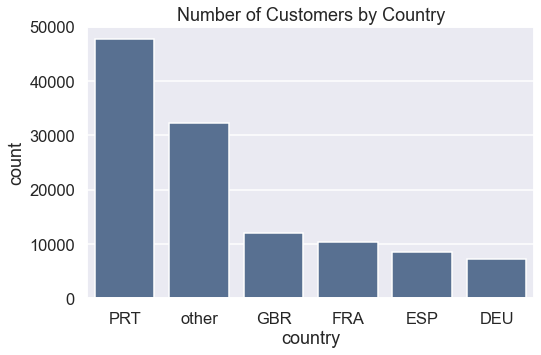

In [26]:
def country_group(country):
    top_countries = ['PRT', 'GBR', 'FRA', 'ESP', 'DEU']
    if country in top_countries:
        return country
    else:
        return 'other'
    
hotels_engineered['country'] = hotels_engineered['country'].apply(country_group)
country_counts = hotels_engineered['country'].value_counts().reset_index()
country_counts.columns = ['country','count']
fig,ax = plt.subplots(figsize=(8,5))
sns.barplot(data=country_counts, x='country',y='count', color=NEUTRAL)
plt.title('Number of Customers by Country');

### Market Segment and Distribution Channel

In [27]:
hotels_engineered['market_segment'].value_counts(normalize=True)

Online TA        0.473859
Offline TA/TO    0.203085
Groups           0.167147
Direct           0.104033
Corporate        0.044021
Complementary    0.005936
Aviation         0.001903
Undefined        0.000017
Name: market_segment, dtype: float64

In [28]:
hotels_engineered['distribution_channel'].value_counts(normalize=True)

TA/TO        0.822088
Direct       0.120851
Corporate    0.055411
GDS          0.001607
Undefined    0.000042
Name: distribution_channel, dtype: float64

It appears that there is some overlap between these features, so it does not make sense to keep both of them. Because groups account for 16% of the reservations and is only defined in the market segment column, I will work with that column and drop the other.

It would be interesting to distinguish between online and offline reservations, but since that information is only available for reservations through travel agents, I will not include it.

I will create 5 major groupings for market segment: TA/TO (travel agent/ tour operator), groups, direct, corporate and other. 

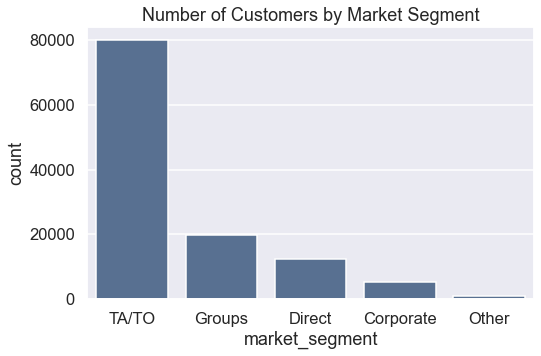

In [29]:
def market_group(market):
    if market == 'Online TA' or market == 'Offline TA/TO':
        return 'TA/TO'
    elif market in ['Groups', 'Direct', 'Corporate']:
        return market
    else:
        return 'Other'
    
hotels_engineered['market_segment'] = hotels_engineered['market_segment'].apply(market_group)
hotels_engineered = hotels_engineered.drop('distribution_channel', axis=1)

segments = hotels_engineered['market_segment'].value_counts().reset_index()
segments.columns=['market_segment','count']
fig,ax = plt.subplots(figsize=(8,5))
sns.barplot(data=segments, x='market_segment',y='count', color=NEUTRAL)
plt.title('Number of Customers by Market Segment');

### Prior Customer Behavior

There are three columns that address prior customer behavior: is_repeated_guest, previous_cancellations and previous_bookings_not_canceled. The last column does not contain any additional information, so will be dropped. The other two are already encoded with 0 and 1.

In [30]:
hotels_engineered = hotels_engineered.drop('previous_bookings_not_canceled',
                                           axis=1)

### Room Type

There are two columns that deal with room type - the reservation and the assigned room type. I am going to keep the reservation column and remove the assigned column, since that information would not be known unless the customer does not cancel. 

In [31]:
hotels_engineered = hotels_engineered.drop('assigned_room_type', axis=1)

In [32]:
hotels_engineered['reserved_room_type'].value_counts(normalize=True)

A    0.720128
D    0.161118
E    0.054777
F    0.024277
G    0.017453
B    0.009411
C    0.007779
H    0.005023
L    0.000034
Name: reserved_room_type, dtype: float64

In [33]:
hotels_engineered.groupby('reserved_room_type')['adr'].mean()

reserved_room_type
A     91.386957
B     90.766379
C    161.804402
D    121.241655
E    125.351304
F    168.574267
G    177.796308
H    189.693754
L    151.000000
Name: adr, dtype: float64

There are ten room types that each appear in both hotels, with A and D accounting for 88% of the reservations. Based on the average price of A and D as well as the frequency, it appears that A is a standard room and D is a premium room. Based on the average prices, I am going to classify A and B as standard rooms, D,E and L as premium and the rest as super_premium. 

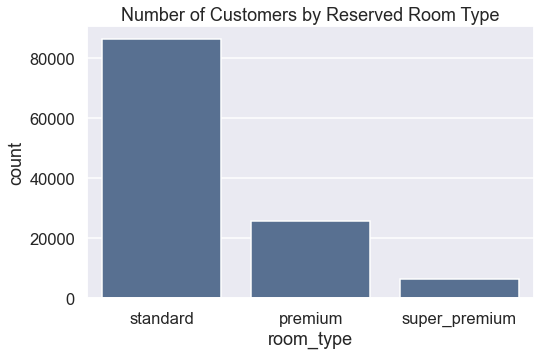

In [34]:
def room_type(room):
    if room in ['A','B']:
        return 'standard'
    elif room in ['D','E','L']:
        return 'premium'
    else:
        return 'super_premium'
    
hotels_engineered['reserved_room_type'] = (
    hotels_engineered['reserved_room_type'].apply(room_type))

room_types = (hotels_engineered['reserved_room_type'].
              value_counts().
              reset_index())
room_types.columns = ['room_type','count']
fig,ax = plt.subplots(figsize=(8,5))
sns.barplot(data=room_types, x='room_type',y='count', color=NEUTRAL)
plt.title('Number of Customers by Reserved Room Type');

### Booking Details

In [35]:
hotels_engineered['booking_changes'].value_counts()

0     100346
1      12578
2       3780
3        923
4        373
5        114
6         62
7         30
8         17
9          8
10         6
13         5
14         5
15         3
11         2
12         2
16         2
17         2
20         1
18         1
21         1
Name: booking_changes, dtype: int64

The majority of customers did not make any changes and of those that did, the most common was a single change. I am going to change this to a binary column: 1 for made changes and 0 for no changes.

In [36]:
hotels_engineered['booking_changes'] = np.where(hotels_engineered['booking_changes']==0, 0, 1)

In [37]:
hotels_engineered['deposit_type'].value_counts()

No Deposit    103530
Non Refund     14569
Refundable       162
Name: deposit_type, dtype: int64

I am going to make a similar adjustment to deposit type since there are so few refundable deposits. The column will be changed to deposit_made with 1 for yes and 0 for no. 

In [38]:
hotels_engineered = hotels_engineered.rename(
    columns={'deposit_type': 'deposit_made'})

def deposit_made(deposit):
    if deposit == 'No Deposit':
        return 0
    else:
        return 1
    
hotels_engineered['deposit_made'] = (
    hotels_engineered['deposit_made'].apply(deposit_made))


In [39]:
hotels_engineered['days_in_waiting_list'].value_counts()

0      114564
39        227
58        164
44        141
31        127
        ...  
175         1
117         1
89          1
92          1
183         1
Name: days_in_waiting_list, Length: 128, dtype: int64

Days in waiting list follows a similar pattern. I am going to replace the column with waiting_list with 1 for a wait and 0 for no wait. 

In [40]:
hotels_engineered = hotels_engineered.rename(
    columns={'days_in_waiting_list': 'waiting_list'})

hotels_engineered['waiting_list'] = (
    np.where(hotels_engineered['waiting_list']==0, 0, 1))

### Booking Agent and Company

In [41]:
hotels_engineered['agent'].value_counts(normalize=True)[:10]

9.0      0.310888
240.0    0.134338
1.0      0.070227
14.0     0.035285
7.0      0.034376
6.0      0.031454
250.0    0.027761
241.0    0.016631
28.0     0.015976
8.0      0.014647
3.0      0.013045
37.0     0.011990
19.0     0.010358
40.0     0.010113
314.0    0.008902
21.0     0.008550
229.0    0.007671
242.0    0.007465
83.0     0.006772
29.0     0.006674
171.0    0.005873
12.0     0.005638
85.0     0.005374
20.0     0.005277
96.0     0.005247
243.0    0.005003
30.0     0.004729
134.0    0.004681
298.0    0.004612
27.0     0.004368
15.0     0.003899
26.0     0.003869
11.0     0.003850
22.0     0.003713
56.0     0.003664
273.0    0.003391
177.0    0.003361
86.0     0.003283
58.0     0.003273
5.0      0.003205
119.0    0.002971
196.0    0.002902
34.0     0.002873
44.0     0.002843
138.0    0.002795
315.0    0.002756
38.0     0.002677
10.0     0.002521
Name: agent, dtype: float64

In [42]:
hotels_engineered['agent'].isna().sum()

15922

There are 3 agents that account for around 50% of the bookings and the rest are made by agents that have small numbers of bookings. There are also 16,115 records with no value for agent. I am going to keep the top 3 agents, replace the missing values with 'none' and group the rest into 'other.'

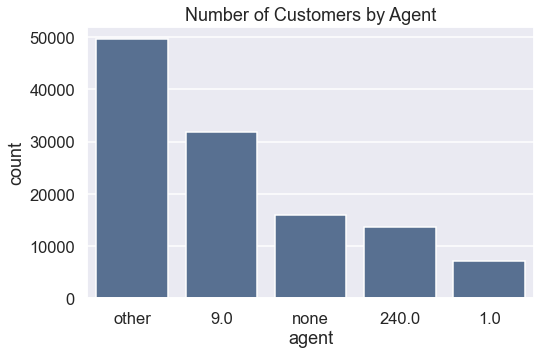

In [43]:
def get_agent(agent):
    if agent in [9.0, 240.0, 1.0]:
        return str(agent)
    elif np.isnan(agent):
        return 'none'
    else:
        return 'other'
    
hotels_engineered['agent'] = hotels_engineered['agent'].apply(get_agent)     
agent_count = hotels_engineered['agent'].value_counts().reset_index()
agent_count.columns = ['agent','count']
fig,ax = plt.subplots(figsize=(8,5))
sns.barplot(data=agent_count, x='agent',y='count', color=NEUTRAL)
plt.title('Number of Customers by Agent');

In [44]:
hotels_engineered['company'].value_counts(normalize=True)

40.0     0.137387
223.0    0.116066
67.0     0.040090
45.0     0.035285
153.0    0.030480
           ...   
373.0    0.000150
499.0    0.000150
347.0    0.000150
140.0    0.000150
461.0    0.000150
Name: company, Length: 349, dtype: float64

In [45]:
hotels_engineered['company'].isna().sum()

111601

There are so many missing values in this column and no single company accounts for more than 13% of the bookings, that I am going to drop this column.

In [46]:
hotels_engineered = hotels_engineered.drop('company', axis=1)

### Average Daily Rate

In [47]:
hotels_engineered['adr'].describe()

count    118261.000000
mean        102.477275
std          50.019486
min          -6.380000
25%          70.000000
50%          95.000000
75%         126.000000
max        5400.000000
Name: adr, dtype: float64

In [48]:
hotels_engineered[((hotels_engineered['adr'] < 0) 
                   | (hotels_engineered['adr'] > 1000))]

,arrival_date,is_canceled,lead_time,arrival_date_week_number,adults,meal,country,market_segment,is_repeated_guest,previous_cancellations,...,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card,city_hotel,stay_length,has_children
14969,2017-03-05,0,7-8_months,10,2,BB,GBR,Groups,1,0,...,0,Check-Out,2017-03-15,Chase Santos,Chase_Santos@outlook.com,472-408-0661,************9176,0,10,0
48515,2016-03-25,1,<_2_months,13,2,BB,PRT,TA/TO,0,0,...,0,Canceled,2016-02-19,Daniel Walter,DanielWalter27@comcast.net,865-280-5832,************6075,1,1,0


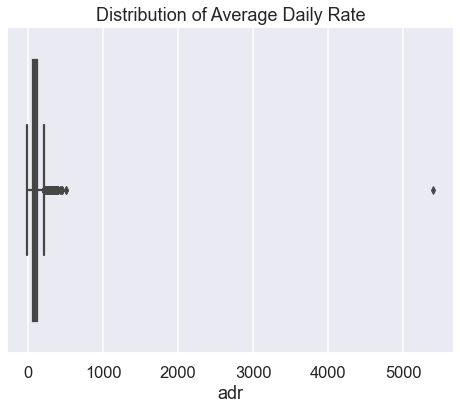

In [49]:
#Examine the distribution of average daily rate
fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(data=hotels_engineered, x='adr')
plt.title('Distribution of Average Daily Rate');

There is clearly an outlier in this column. Whereas the median daily rate is 95, the maximum is 5,400. Additionally, there is one record with an average daily rate below 0. I am going to remove these two records. 

In [50]:
hotels_engineered = hotels_engineered[((hotels_engineered['adr'] >= 0) 
                   & (hotels_engineered['adr'] < 1000))]

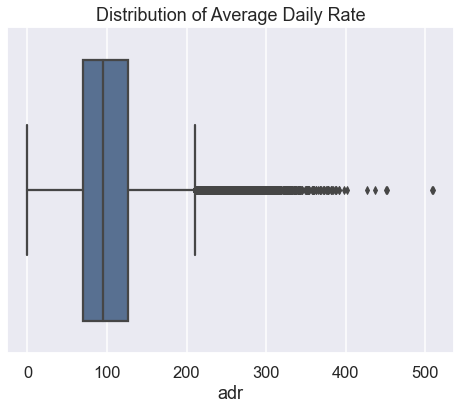

In [51]:
#Examine the distribution after the removal of outliers
fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(data=hotels_engineered, x='adr')
plt.title('Distribution of Average Daily Rate');

### Special Requests

In [52]:
hotels_engineered['total_of_special_requests'].value_counts()

0    69535
1    32982
2    12879
3     2483
4      340
5       40
Name: total_of_special_requests, dtype: int64

Because the number of special requests rapidly drops off after 2, I am going to group these as: 0, 1, 2 and 3+.

In [53]:
def get_requests(request):
    if request in [0,1,2]:
        return str(request)
    else:
        return '3+'

hotels_engineered['total_of_special_requests'] = (
    hotels_engineered['total_of_special_requests'].apply(get_requests))

## Observations Removed

A total of 1,131 observations were removed. This is about 0.95% of the data.

## Feature Selection

In [54]:
hotels_engineered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118259 entries, 2 to 119389
Data columns (total 28 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   arrival_date                 118259 non-null  datetime64[ns]
 1   is_canceled                  118259 non-null  int64         
 2   lead_time                    118259 non-null  object        
 3   arrival_date_week_number     118259 non-null  int64         
 4   adults                       118259 non-null  object        
 5   meal                         118259 non-null  object        
 6   country                      118259 non-null  object        
 7   market_segment               118259 non-null  object        
 8   is_repeated_guest            118259 non-null  int64         
 9   previous_cancellations       118259 non-null  int64         
 10  reserved_room_type           118259 non-null  object        
 11  booking_changes           

The columns with name, phone, email and credit card have synthetic data for anonymity and so can be removed. 

The columns of reservation status and reservation status date will need to be removed for modeling since I am using 'is_canceled' as the target and those two columns contain information that relates to the target. 

I am also going to remove:
arrival date (too granular, and keeping arrival week number to account for seasonal changes),
meal (not enough variation or relevant information),
required_car_parking_spaces (not enough variation or relevant information)


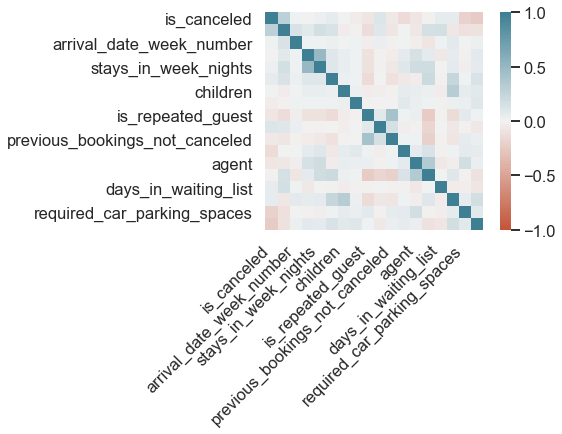

In [55]:
#Checking correlations with features
corr = hotels.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [56]:
target_features = ['is_canceled', 'lead_time', 'arrival_date_week_number',
       'adults', 'country', 'market_segment', 'is_repeated_guest',
       'previous_cancellations', 'reserved_room_type', 'booking_changes',
       'deposit_made', 'agent', 'waiting_list', 'customer_type', 'adr',
       'total_of_special_requests','city_hotel', 'stay_length',
       'has_children']

hotels_cleaned = hotels_engineered.copy()
hotels_cleaned = hotels_cleaned[target_features]
hotels_cleaned.head()

,is_canceled,lead_time,arrival_date_week_number,adults,country,market_segment,is_repeated_guest,previous_cancellations,reserved_room_type,booking_changes,deposit_made,agent,waiting_list,customer_type,adr,total_of_special_requests,city_hotel,stay_length,has_children
2,0,<_2_months,27,1,GBR,Direct,0,0,standard,0,0,none,0,Transient,75.0,0,0,1,0
3,0,<_2_months,27,1,GBR,Corporate,0,0,standard,0,0,other,0,Transient,75.0,0,0,1,0
4,0,<_2_months,27,2,GBR,TA/TO,0,0,standard,0,0,240.0,0,Transient,98.0,1,0,2,0
5,0,<_2_months,27,2,GBR,TA/TO,0,0,standard,0,0,240.0,0,Transient,98.0,1,0,2,0
6,0,none,27,2,PRT,Direct,0,0,super_premium,0,0,none,0,Transient,107.0,0,0,2,0


# Modeling

## Goals for Modeling

The goal is to create a model that can be used by the hotels to predict which customers are likely to cancel their reservations. 

If this information is used to implement policy changes that may negatively impact customers that are falsely identified as potentially canceling (i.e. requiring a deposit or overbooking rooms), it is important to have high precision. However, if the goal is to identify as many potential cancellations as possible and the policy changes don't negatively impact customers falsely identified as cancellations (i.e. sending a reminder email or offering last-minute specials during times when cancellations are more likely to occur), it is important to have high recall.

Since this situation has arguments for both high precision and recall and there are no catastrophic consequences foreseen for either false positives or false negatives, it makes the most sense to select a model that balances precision and recall and has a high overall accuracy. 

## Data Preparation

In [57]:
#Split the data into train, validation and test sets.
y = hotels_cleaned['is_canceled']
X = hotels_cleaned.drop('is_canceled', axis=1)

X_train, X_, y_train, y_ = train_test_split(X,
                                           y,
                                           stratify=y, 
                                           random_state=SEED,
                                           test_size=.30)
X_val, X_test, y_val, y_test = train_test_split(X_,
                                                y_,
                                                stratify=y_, 
                                                random_state=SEED,
                                                test_size=.5)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape,y_test.shape

((82781, 18), (17739, 18), (17739, 18), (82781,), (17739,), (17739,))

In [58]:
#Identify categorical and numeric columns in X_train.
cat_cols = X_train.select_dtypes('object').columns
num_cols = X_train.select_dtypes('number').columns

#One hot encode the categorical features and scale the numeric features.
num_transformer = Pipeline([('scale', StandardScaler())])
cat_transformer = Pipeline([('ohe', OneHotEncoder(drop='first', sparse=False))])


transformer = ColumnTransformer([
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols),
    ])

preprocess = Pipeline([('transformer', transformer)])

X_train_processed = preprocess.fit_transform(X_train)
X_train_processed_df = pd.DataFrame(X_train_processed)

X_val_processed = preprocess.transform(X_val)

cat_names = (preprocess.named_steps['transformer']
             .transformers_[1][1].named_steps['ohe']
             .get_feature_names(cat_cols))
feature_names = list(num_cols) + list(cat_names)

In [ ]:
#Indicies for categorical variables.
i_1 = len(num_cols)+1
i_2 = len(feature_names)

#Perform oversampling on the training set to create balanced classes. 
oversampler = SMOTENC(categorical_features = list(range(i_1,i_2)), 
                      n_jobs=-2, 
                      random_state=SEED)


# X_train_smote, y_train_smote = oversampler.fit_resample(X_train_processed, 
                                                          y_train)

In [285]:
X_smote_file = 'X_smote.pk1'
# joblib.dump(X_train_smote, X_smote_file)
X_train_smote = joblib.load(X_smote_file)

y_smote_file = 'y_smote.pk1'
# joblib.dump(y_train_smote, y_smote_file)
y_train_smote = joblib.load(y_smote_file)


X_train_smote.shape, y_train_smote.shape

((104278, 39), (104278,))

## Model Training and Evaluation Functions and Dictionaries

In [60]:
#A dictionary with the basic classification algorithms. 
clf_dict = {'log_r': LogisticRegression(
               class_weight='balanced', 
               max_iter=2000),
           'knn': KNeighborsClassifier(
               n_jobs=-2),
           'svc': SVC(random_state=SEED,
                     class_weight='balanced'),
           'tree': DecisionTreeClassifier(
               random_state=SEED,
               class_weight='balanced'),
           'forest': RandomForestClassifier(
               random_state=SEED,
               n_jobs=-2,
               class_weight='balanced'),
           'GB_clf': GradientBoostingClassifier(random_state=SEED),
           'ada': AdaBoostClassifier(random_state=SEED),
           'xgb': xgb.XGBClassifier(random_state=SEED)}

# A dictionary with the scoring methods for model evaluation.
scoring = {'AUC': 'roc_auc',
          'Accuracy': make_scorer(accuracy_score),
          'Recall': make_scorer(recall_score),
          'Precision': make_scorer(precision_score),
          'F1': make_scorer(f1_score)}

In [61]:
screen_dict = {}

def screen_model(clf, clf_dict, scoring, X, y):
    """Takes in the classifier key from the classifier dictionary, the
    classifier dictionary, a scoring dictionary and an X and y and runs
    a 5-fold cross_validation. The scores are reported and added to a 
    dictionary."""
    
    clf_screen = {}

    score = cross_validate(clf_dict[clf],
                    X,
                    y,
                    scoring=scoring,
                    cv=5,
                    return_train_score=True,
                    n_jobs=-2)

    for k,v in score.items():
        clf_screen[f'{k} mean'] = v.mean()
        clf_screen[f'{k} std'] = v.std()
        
    screen_dict[clf] = clf_screen
    return screen_dict[clf]


In [119]:
def get_pred(clf, clf_dict, X_train, y_train, X_val, y_val):
    """Takes in a classifier, the classifier dictionary, the train and
    validation sets and returns the predicted y values on the validation
    set."""
    clf = clf_dict[clf]
    clf.fit(X_train, y_train)
    y_val_pred = clf.predict(X_val)
    return y_val_pred
    
def get_report(clf, clf_dict, X_train, y_train, X_val, y_val):  
    """Takes in a classifier, the classifier dictionary, the train and
    validation sets and returns the classifation report for the validation 
    set."""
    y_val_pred = get_pred(clf, clf_dict, X_train, y_train, X_val, y_val)
    report = classification_report(y_val, y_val_pred, output_dict=True)
    report = pd.DataFrame(report).T
    return report

## Initial Model Selection

### Baseline Model

In [63]:
baseline_model = DummyClassifier(random_state=SEED)
baseline_model.fit(X_train, y_train)
baseline_pred = baseline_model.predict(X_val)
baseline_score = accuracy_score(y_val, baseline_pred)
baseline_score

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "


0.5313151812390777

### Logistic Regression

In [178]:
# log_r = screen_model('log_r', clf_dict, scoring, X_train_smote, y_train_smote)
log_r_file = 'log_r.pk1'
# joblib.dump(log_r, log_r_file)
log_r_f = joblib.load(log_r_file)
screen_dict['log_r'] = log_r_f
screen_dict['log_r']

{'fit_time mean': 2.4799670219421386,
 'fit_time std': 0.31651342311878966,
 'score_time mean': 0.03736081123352051,
 'score_time std': 0.0076141143558556374,
 'test_AUC mean': 0.898556686592207,
 'test_AUC std': 0.006645597911619937,
 'train_AUC mean': 0.8995200870617286,
 'train_AUC std': 0.0016855445773638813,
 'test_Accuracy mean': 0.8057118511592594,
 'test_Accuracy std': 0.008485590441713289,
 'train_Accuracy mean': 0.8061456035804575,
 'train_Accuracy std': 0.002050000610200401,
 'test_Recall mean': 0.7881436721791545,
 'test_Recall std': 0.02054148920102017,
 'train_Recall mean': 0.7895865072290356,
 'train_Recall std': 0.0032193173251854404,
 'test_Precision mean': 0.8168298845962625,
 'test_Precision std': 0.001982375777106115,
 'train_Precision mean': 0.8166290108574422,
 'train_Precision std': 0.0014240487453482482,
 'test_F1 mean': 0.8021032851065282,
 'test_F1 std': 0.010988024044035746,
 'train_F1 mean': 0.8028787941322861,
 'train_F1 std': 0.0023138551515097783}

In [121]:
log_r_report = get_report('log_r', 
           clf_dict, 
           X_train_smote, 
           y_train_smote, 
           X_val_processed, 
           y_val)
log_r_report

,precision,recall,f1-score,support
0,0.864847,0.828157,0.846105,11173.000000
1,0.727273,0.779775,0.752609,6566.000000
accuracy,0.810249,0.810249,0.810249,0.810249
macro avg,0.796060,0.803966,0.799357,17739.000000
weighted avg,0.813925,0.810249,0.811498,17739.000000


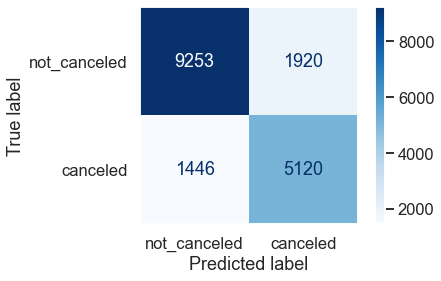

In [66]:
log_r_matrix = plot_confusion_matrix(clf_dict['log_r'], 
                      X_val_processed, 
                      y_val,
                      display_labels=CLASS_NAMES,
                      cmap=plt.cm.Blues)
plt.grid(None);
log_r_matrix

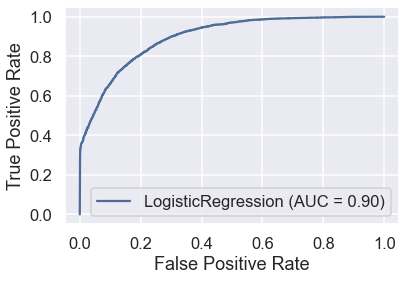

In [67]:
log_r_roc = plot_roc_curve(clf_dict['log_r'],X_val_processed, y_val);
log_r_roc

#### Preliminary Evaluation

Pros:
- consistency between train and test sets with cross-validation implies little overfitting
- the precision and recall scores are balanced

Cons:
- it does better with both precision and recall at predicting the negative class (those that don't cancel) than the positive class (those that do cancel); very low precision and recall on the positive class
- the accuracy is only around 81%

Evaluate further: No

Tuning goals:
- increase C value to make the model more complex to try to improve accuracy and precision/recall for the positive class

### K-Nearest Neighbors

In [179]:
# knn = screen_model('knn', clf_dict, scoring, X_train_smote, y_train_smote)
knn_file = 'knn.pk1'
# joblib.dump(knn, knn_file)
knn_f = joblib.load(knn_file)
screen_dict['knn'] = knn_f
screen_dict['knn']

{'fit_time mean': 62.53900179862976,
 'fit_time std': 0.5029637459278608,
 'score_time mean': 82.71241383552551,
 'score_time std': 3.574105720418155,
 'test_AUC mean': 0.9282835932988245,
 'test_AUC std': 0.015734293284267595,
 'train_AUC mean': 0.9716268541799344,
 'train_AUC std': 0.0029650171942245075,
 'test_Accuracy mean': 0.8545910016528724,
 'test_Accuracy std': 0.016589871007065427,
 'train_Accuracy mean': 0.9001491464350766,
 'train_Accuracy std': 0.004410751683123473,
 'test_Recall mean': 0.8883953369120892,
 'test_Recall std': 0.03647477152987325,
 'train_Recall mean': 0.923037515126483,
 'train_Recall std': 0.009458936075855278,
 'test_Precision mean': 0.8320299129074789,
 'test_Precision std': 0.00382309416829272,
 'train_Precision mean': 0.8826284250779182,
 'train_Precision std': 0.0005555821203279891,
 'test_F1 mean': 0.8589894430168895,
 'test_F1 std': 0.018601680327363392,
 'train_F1 mean': 0.9023597351845257,
 'train_F1 std': 0.004803018388681402}

In [69]:
knn_report = get_report('knn', 
           clf_dict, 
           X_train_smote, 
           y_train_smote, 
           X_val_processed, 
           y_val)

knn_report

              precision    recall  f1-score   support

           0       0.89      0.83      0.86     11173
           1       0.74      0.82      0.78      6566

    accuracy                           0.83     17739
   macro avg       0.81      0.82      0.82     17739
weighted avg       0.83      0.83      0.83     17739



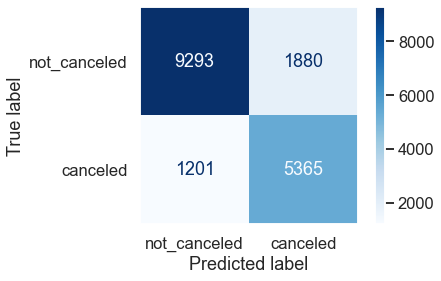

In [70]:
knn_matrix = plot_confusion_matrix(clf_dict['knn'], 
                      X_val_processed, 
                      y_val,
                      display_labels=CLASS_NAMES,
                      cmap=plt.cm.Blues)
plt.grid(None);
knn_matrix

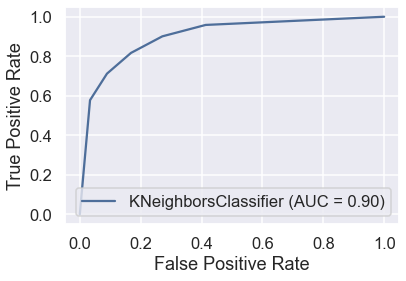

In [71]:
knn_roc = plot_roc_curve(clf_dict['knn'],X_val_processed, y_val);
knn_roc

   #### Preliminary Evaluation

Pros:
- recall is consistent for both positive and negative class
- precision and F1 good for negative class

Cons:
- differences in train and test results imply overfitting

Evaluate further: No

Tuning goals:
- increase k to reduce overfitting

### Support Vector Classifier

In [180]:
# svc = screen_model('svc', clf_dict, scoring, X_train_smote, y_train_smote)
svc_file = 'svc.pk1'
# joblib.dump(svc, svc_file)
svc_f = joblib.load(svc_file)
screen_dict['svc'] = svc_f
screen_dict['svc']

{'fit_time mean': 411.34262976646426,
 'fit_time std': 53.30540746327509,
 'score_time mean': 75.42806472778321,
 'score_time std': 0.4226196972523446,
 'test_AUC mean': 0.9252319230400919,
 'test_AUC std': 0.008599832830773986,
 'train_AUC mean': 0.9308521688234427,
 'train_AUC std': 0.0018891464793555374,
 'test_Accuracy mean': 0.8422775811429991,
 'test_Accuracy std': 0.008878529173285663,
 'train_Accuracy mean': 0.8478442384457798,
 'train_Accuracy std': 0.0024557756229335015,
 'test_Recall mean': 0.8243738602560574,
 'test_Recall std': 0.021888980757768146,
 'train_Recall mean': 0.8302470400492725,
 'train_Recall std': 0.003961164723183379,
 'test_Precision mean': 0.8550013382875756,
 'test_Precision std': 0.0012113514548916053,
 'train_Precision mean': 0.8605344763356321,
 'train_Precision std': 0.0022396456290968516,
 'test_F1 mean': 0.8392554583679978,
 'test_F1 std': 0.011106999426415676,
 'train_F1 mean': 0.8451153678881408,
 'train_F1 std': 0.0026826020000329976}

In [127]:
# svc_report = get_report('svc', 
#            clf_dict, 
#            X_train_smote, 
#            y_train_smote, 
#            X_val_processed, 
#            y_val)

svc_report_file = 'svc_report.pk1'
# joblib.dump(svc_report, svc_report_file)
svc_report = joblib.load(svc_report_file)
svc_report

,0,1,accuracy,macro avg,weighted avg
precision,0.886177,0.782385,0.846384,0.834281,0.847759
recall,0.867538,0.810387,0.846384,0.838962,0.846384
f1-score,0.876758,0.796140,0.846384,0.836449,0.846918
support,11173.000000,6566.000000,0.846384,17739.000000,17739.000000


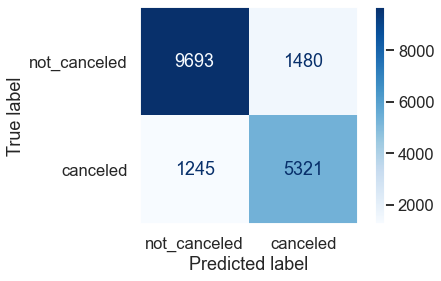

In [77]:
svc_matrix = plot_confusion_matrix(clf_dict['svc'], 
                      X_val_processed, 
                      y_val,
                      display_labels=CLASS_NAMES,
                      cmap=plt.cm.Blues)
plt.grid(None)
svc_matrix

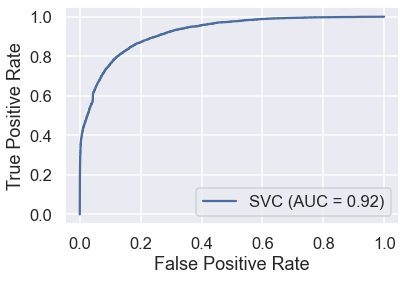

In [78]:
svc_roc = plot_roc_curve(clf_dict['svc'],X_val_processed, y_val);
svc_roc

#### Preliminary Evaluation

Pros:
- consistent performance across folds
- does not appear to be overfitting
- balanced precision and recall scores

Cons:
- better at predicting the negative class than the positive class

Evaluate further: Yes

Tuning goals:
- try linear kernel
- increase C to improve accuracy (since there is little sign of overfitting currently)
- increase gamma to increase complexity


### Decision Tree

In [181]:
# tree = screen_model('tree', clf_dict, scoring, X_train_smote, y_train_smote)
tree_file = 'tree.pk1'
# joblib.dump(tree, tree_file)
tree_f = joblib.load(tree_file)
screen_dict['tree'] = tree_f
screen_dict['tree']

{'fit_time mean': 0.739148759841919,
 'fit_time std': 0.0071070450252161575,
 'score_time mean': 0.037216567993164064,
 'score_time std': 0.0014581425940900458,
 'test_AUC mean': 0.8524293801019178,
 'test_AUC std': 0.021779001604650076,
 'train_AUC mean': 0.999890952738696,
 'train_AUC std': 2.6284494128454433e-05,
 'test_Accuracy mean': 0.8491345392046586,
 'test_Accuracy std': 0.021112912253852624,
 'train_Accuracy mean': 0.9931864874374291,
 'train_Accuracy std': 0.0008830357587089451,
 'test_Recall mean': 0.849480441753909,
 'test_Recall std': 0.05576069422178749,
 'train_Recall mean': 0.9916761123127017,
 'train_Recall std': 0.0023458675226613952,
 'test_Precision mean': 0.8491156576734413,
 'test_Precision std': 0.004083480191183402,
 'train_Precision mean': 0.9946962249376916,
 'train_Precision std': 0.003058382638526519,
 'test_F1 mean': 0.848288897064738,
 'test_F1 std': 0.025996285811409454,
 'train_F1 mean': 0.9931771573338966,
 'train_F1 std': 0.00087630247434847}

In [80]:
tree_report = get_report('tree', 
           clf_dict, 
           X_train_smote, 
           y_train_smote, 
           X_val_processed, 
           y_val)

tree_report

              precision    recall  f1-score   support

           0       0.88      0.86      0.87     11173
           1       0.77      0.80      0.78      6566

    accuracy                           0.83     17739
   macro avg       0.82      0.83      0.82     17739
weighted avg       0.84      0.83      0.83     17739



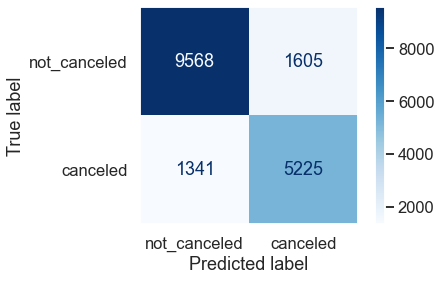

In [81]:
tree_matrix = plot_confusion_matrix(clf_dict['tree'], 
                      X_val_processed, 
                      y_val,
                      display_labels=CLASS_NAMES,
                      cmap=plt.cm.Blues)
plt.grid(None)
tree_matrix

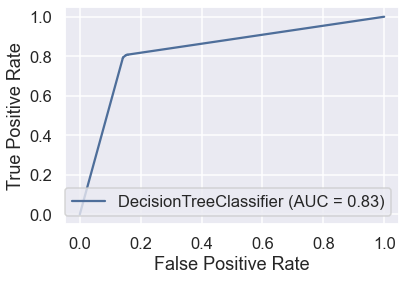

In [82]:
tree_roc = plot_roc_curve(clf_dict['tree'],X_val_processed, y_val);
tree_roc

#### Preliminary Evaluation

Pros:
- performs well on training data
- precision and recall are balanced

Cons:
- badly overfitting

Evaluate further: No

Tuning goals:

### Random Forest

In [167]:
# forest = screen_model('forest', clf_dict, scoring, X_train_smote, y_train_smote)
forest_file = 'forest.pk1'
# joblib.dump(forest, forest_file)
forest_f = joblib.load(forest_file)
screen_dict['forest'] = forest_f
screen_dict['forest']

{'fit_time mean': 9.967270469665527,
 'fit_time std': 0.7274716752366345,
 'score_time mean': 0.5176458358764648,
 'score_time std': 0.15784529937552083,
 'test_AUC mean': 0.9584307053265734,
 'test_AUC std': 0.015376882278911487,
 'train_AUC mean': 0.9994991265971589,
 'train_AUC std': 6.044365736347167e-05,
 'test_Accuracy mean': 0.8852208704098485,
 'test_Accuracy std': 0.025332694208969782,
 'train_Accuracy mean': 0.9931816925392007,
 'train_Accuracy std': 0.0008789518277470821,
 'test_Recall mean': 0.8825078360011404,
 'test_Recall std': 0.06041766472933108,
 'train_Recall mean': 0.9932584097608752,
 'train_Recall std': 0.0008154303429316399,
 'test_Precision mean': 0.8874583514353123,
 'test_Precision std': 0.0026576555263816753,
 'train_Precision mean': 0.9931062042809993,
 'train_Precision std': 0.0009592632132041132,
 'test_F1 mean': 0.8838868379058524,
 'test_F1 std': 0.029066809313552894,
 'train_F1 mean': 0.9931822799782303,
 'train_F1 std': 0.0008783564760839715}

In [123]:
forest_report = get_report('forest', 
           clf_dict, 
           X_train_smote, 
           y_train_smote, 
           X_val_processed, 
           y_val)

forest_report

,0,1,accuracy,macro avg,weighted avg
precision,0.887891,0.817285,0.862055,0.852588,0.861757
recall,0.893851,0.807950,0.862055,0.850901,0.862055
f1-score,0.890861,0.812591,0.862055,0.851726,0.861890
support,11173.000000,6566.000000,0.862055,17739.000000,17739.000000


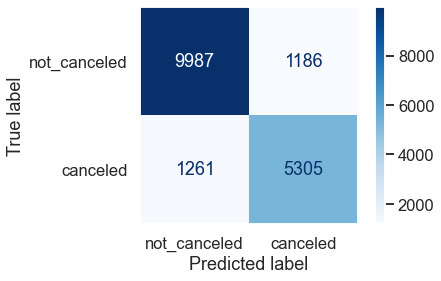

In [85]:
forest_matrix = plot_confusion_matrix(clf_dict['forest'], 
                      X_val_processed, 
                      y_val,
                      display_labels=CLASS_NAMES,
                      cmap=plt.cm.Blues)
plt.grid(None)
forest_matrix

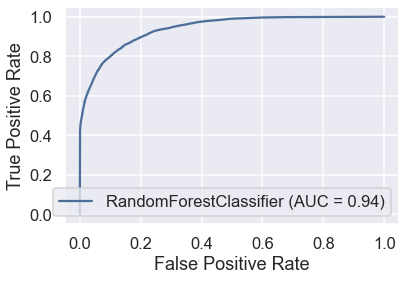

In [86]:
forest_roc = plot_roc_curve(clf_dict['forest'],X_val_processed, y_val);
forest_roc

#### Preliminary Evaluation

Pros:
- did very well on training data
- very balanced precision and recall scores
- did better on predicting positive class than some other models
- higher accuracy

Cons:
- severely overfitting 

Evaluate further: Yes

Tuning goals:
- reduce max depth to reduce overfitting
- increase number of estimators to reduce overfitting

### Gradient Boosting Classifier

In [182]:
# GB_clf = screen_model('GB_clf', clf_dict, scoring, X_train_smote, y_train_smote)
GB_clf_file = 'GB_clf.pk1'
# joblib.dump(GB_clf, GB_clf_file)
GB_clf_f = joblib.load(GB_clf_file)
screen_dict['GB_clf'] = GB_clf_f
screen_dict['GB_clf']

{'fit_time mean': 23.868026208877563,
 'fit_time std': 0.18439095896947638,
 'score_time mean': 0.11172552108764648,
 'score_time std': 0.006515195639907923,
 'test_AUC mean': 0.9218953611460746,
 'test_AUC std': 0.010953727080420281,
 'train_AUC mean': 0.9240866892873651,
 'train_AUC std': 0.0036927705538832355,
 'test_Accuracy mean': 0.8306837137938109,
 'test_Accuracy std': 0.01505962636597863,
 'train_Accuracy mean': 0.8334764093324925,
 'train_Accuracy std': 0.005137000777192183,
 'test_Recall mean': 0.8276154335681511,
 'test_Recall std': 0.03648752999629791,
 'train_Recall mean': 0.8321218644535977,
 'train_Recall std': 0.006108674808148705,
 'test_Precision mean': 0.8326969829311409,
 'test_Precision std': 0.0018399420701916472,
 'train_Precision mean': 0.8343788494860798,
 'train_Precision std': 0.0047745391176927734,
 'test_F1 mean': 0.8297633469952375,
 'test_F1 std': 0.01860437545325617,
 'train_F1 mean': 0.8332461394841977,
 'train_F1 std': 0.005275305347562602}

In [183]:
gb_report = get_report('GB_clf', 
           clf_dict, 
           X_train_smote, 
           y_train_smote, 
           X_val_processed, 
           y_val)

gb_report

,0,1,accuracy,macro avg,weighted avg
precision,0.882937,0.752868,0.831163,0.817902,0.834793
recall,0.843820,0.809625,0.831163,0.826723,0.831163
f1-score,0.862935,0.780216,0.831163,0.821576,0.832317
support,11173.000000,6566.000000,0.831163,17739.000000,17739.000000


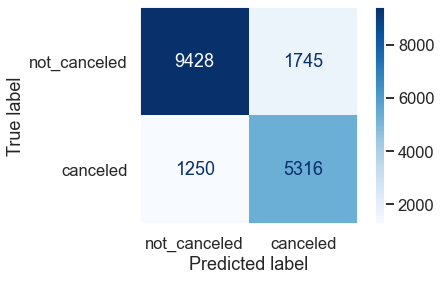

In [89]:
gb_matrix = plot_confusion_matrix(clf_dict['GB_clf'], 
                      X_val_processed, 
                      y_val,
                      display_labels=CLASS_NAMES,
                      cmap=plt.cm.Blues)
plt.grid(None)

gb_matrix

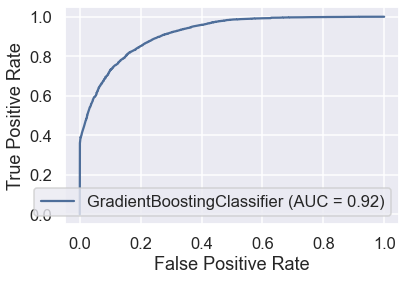

In [90]:
gb_roc = plot_roc_curve(clf_dict['GB_clf'],X_val_processed, y_val);
gb_roc

#### Preliminary Evaluation

Pros:
- not overfitting
- high precision on negative class

Cons:
- poor precision om the positive class compared to other metrics

Evaluate further: No

Tuning goals:

### ADA Boost

In [184]:
# ada = screen_model('ada', clf_dict, scoring, X_train_smote, y_train_smote)
ada_file = 'ada.pk1'
# joblib.dump(ada, ada_file)
ada_f = joblib.load(ada_file)
screen_dict['ada'] = ada_f
screen_dict['ada']

{'fit_time mean': 5.501328754425049,
 'fit_time std': 0.06068649932639238,
 'score_time mean': 0.3425145626068115,
 'score_time std': 0.010646498219128235,
 'test_AUC mean': 0.8998535761231654,
 'test_AUC std': 0.008939921618041462,
 'train_AUC mean': 0.9021943487129755,
 'train_AUC std': 0.003506286115572813,
 'test_Accuracy mean': 0.803496676459934,
 'test_Accuracy std': 0.011068408033061954,
 'train_Accuracy mean': 0.8066538683104414,
 'train_Accuracy std': 0.0035802215976909373,
 'test_Recall mean': 0.7730303497503549,
 'test_Recall std': 0.028990438323111465,
 'train_Recall mean': 0.7784815923636307,
 'train_Recall std': 0.005078041332639991,
 'test_Precision mean': 0.8232203998264721,
 'test_Precision std': 0.0022211999015611765,
 'train_Precision mean': 0.8249604645995552,
 'train_Precision std': 0.0031909358235289596,
 'test_F1 mean': 0.7970448928149672,
 'test_F1 std': 0.015017656137886208,
 'train_F1 mean': 0.8010434912510902,
 'train_F1 std': 0.003945632318488931}

In [92]:
ada_report = get_report('ada', 
           clf_dict, 
           X_train_smote, 
           y_train_smote, 
           X_val_processed, 
           y_val)

ada_report

              precision    recall  f1-score   support

           0       0.85      0.84      0.85     11173
           1       0.74      0.76      0.75      6566

    accuracy                           0.81     17739
   macro avg       0.80      0.80      0.80     17739
weighted avg       0.81      0.81      0.81     17739



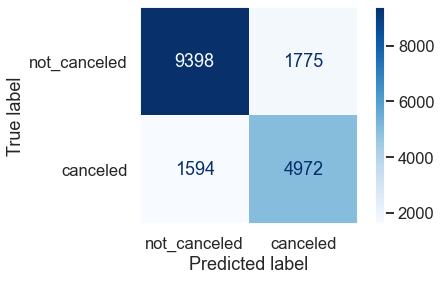

In [93]:
ada_matrix = plot_confusion_matrix(clf_dict['ada'], 
                      X_val_processed, 
                      y_val,
                      display_labels=CLASS_NAMES,
                      cmap=plt.cm.Blues)
plt.grid(None)

ada_matrix

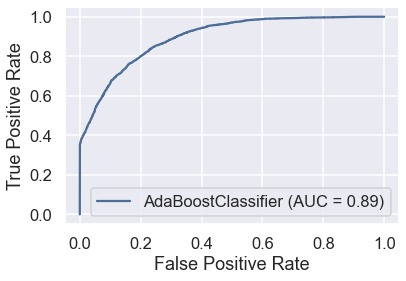

In [94]:
ada_roc = plot_roc_curve(clf_dict['ada'],X_val_processed, y_val);
ada_roc

#### Preliminary Evaluation

Pros:
- not overfitting
- balanced precision and recall scores

Cons:
- poor at predicting the positive class
- lower accuracy

Evaluate further: No

Tuning goals:

### XGBoost

In [191]:
# xgb = screen_model('xgb', clf_dict, scoring, X_train_smote, y_train_smote)
xgb_file = 'xgb.pk1'
# joblib.dump(xgb, xgb_file)
xgb_f = joblib.load(xgb_file)
screen_dict['xgb'] = xgb_f
screen_dict['xgb']

{'fit_time mean': 23.33214259147644,
 'fit_time std': 0.19841177196886214,
 'score_time mean': 0.2792414665222168,
 'score_time std': 0.0067058127193817055,
 'test_AUC mean': 0.9536040128283654,
 'test_AUC std': 0.022661179368304845,
 'train_AUC mean': 0.9660972892648776,
 'train_AUC std': 0.005588502560960043,
 'test_Accuracy mean': 0.8722653374897472,
 'test_Accuracy std': 0.03479161686443435,
 'train_Accuracy mean': 0.8943234047775055,
 'train_Accuracy std': 0.009813042543487532,
 'test_Recall mean': 0.8587832446737578,
 'test_Recall std': 0.08219462169576272,
 'train_Recall mean': 0.8873971930459778,
 'train_Recall std': 0.007406508165600999,
 'test_Precision mean': 0.8827281439407269,
 'test_Precision std': 0.0020015191085289022,
 'train_Precision mean': 0.8999209785613814,
 'train_Precision std': 0.011891078273274815,
 'test_F1 mean': 0.868558454406771,
 'test_F1 std': 0.04082734817194011,
 'train_F1 mean': 0.8936097383328286,
 'train_F1 std': 0.00961292700435676}

In [124]:
xgb_report = get_report('xgb', 
           clf_dict, 
           X_train_smote, 
           y_train_smote, 
           X_val_processed, 
           y_val)
xgb_report

,0,1,accuracy,macro avg,weighted avg
precision,0.885094,0.812009,0.858335,0.848552,0.858042
recall,0.890719,0.803229,0.858335,0.846974,0.858335
f1-score,0.887898,0.807595,0.858335,0.847746,0.858174
support,11173.000000,6566.000000,0.858335,17739.000000,17739.000000


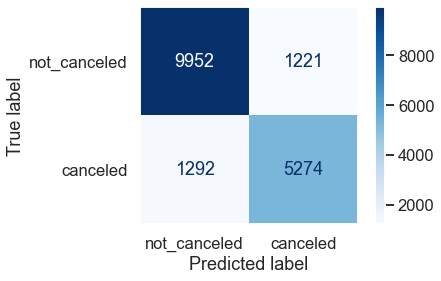

In [97]:
xgb_matrix = plot_confusion_matrix(clf_dict['xgb'], 
                      X_val_processed, 
                      y_val,
                      display_labels=CLASS_NAMES,
                      cmap=plt.cm.Blues)
plt.grid(None)
xgb_matrix

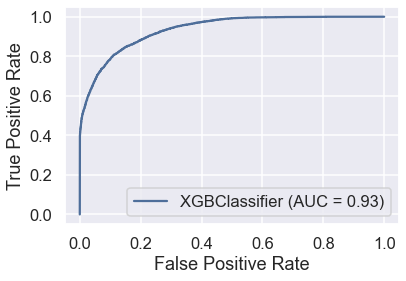

In [98]:
xgb_roc = plot_roc_curve(clf_dict['xgb'],X_val_processed, y_val);
xgb_roc

#### Preliminary Evaluation

Pros:
- very balanced between precision and recall
- does better at predicting the positive class than the other models (although still lower than the negative class)

Cons:
- some overfitting

Evaluate further: yes

Tuning goals:
- adjust learning rate and number of estimators

## Summary of Initial Models

In [264]:
initial_model_metrics = pd.DataFrame(screen_dict)
initial_model_metrics

,svc,forest,log_r,knn,tree,GB_clf,ada,xgb
fit_time mean,411.342630,9.967270,2.479967,62.539002,0.739149,23.868026,5.501329,23.332143
fit_time std,53.305407,0.727472,0.316513,0.502964,0.007107,0.184391,0.060686,0.198412
score_time mean,75.428065,0.517646,0.037361,82.712414,0.037217,0.111726,0.342515,0.279241
score_time std,0.422620,0.157845,0.007614,3.574106,0.001458,0.006515,0.010646,0.006706
test_AUC mean,0.925232,0.958431,0.898557,0.928284,0.852429,0.921895,0.899854,0.953604
test_AUC std,0.008600,0.015377,0.006646,0.015734,0.021779,0.010954,0.008940,0.022661
train_AUC mean,0.930852,0.999499,0.899520,0.971627,0.999891,0.924087,0.902194,0.966097
train_AUC std,0.001889,0.000060,0.001686,0.002965,0.000026,0.003693,0.003506,0.005589
test_Accuracy mean,0.842278,0.885221,0.805712,0.854591,0.849135,0.830684,0.803497,0.872265
test_Accuracy std,0.008879,0.025333,0.008486,0.016590,0.021113,0.015060,0.011068,0.034792


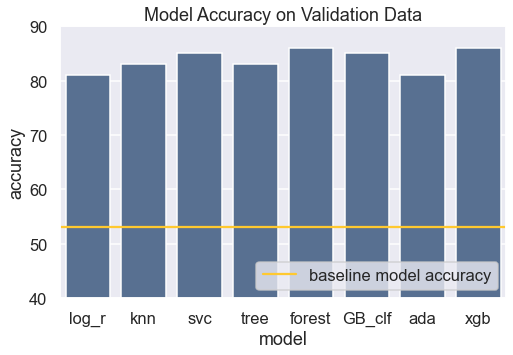

In [100]:
accuracy_df = pd.DataFrame({'clf' : clf_dict.keys()})
accuracy_df['accuracy'] = [81,83,85,83,86,85,81,86]
fig,ax = plt.subplots(figsize=(8,5))
sns.barplot(data=accuracy_df, x='clf',y='accuracy', color=NEUTRAL)
plt.ylim([40,90])
plt.axhline(baseline_score*100, color=NEG, label='baseline model accuracy')
plt.legend(loc='lower right')
plt.title('Model Accuracy on Validation Data')
plt.xlabel('model');

All of the models are a significant improvement from the baseline.

Baseline Accuracy: 53%
Model Accuracies: 80-87%

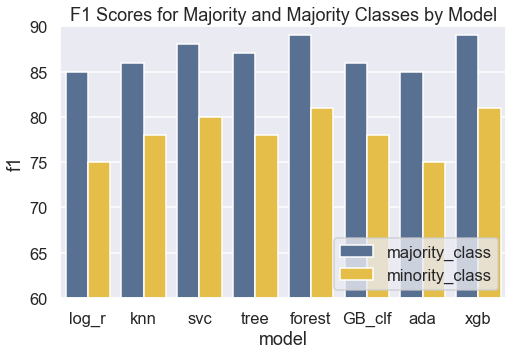

In [101]:
validation_f1 = pd.DataFrame({'clf' : clf_dict.keys()})
validation_f1['majority_class'] = [85,86,88,87,89,86,85,89]
validation_f1['minority_class'] = [75,78,80,78,81,78,75,81]

fig,ax = plt.subplots(figsize=(8,5))
df = pd.melt(validation_f1, 
             id_vars='clf', 
             var_name='class', 
             value_name='f1')
sns.barplot(data=df, x='clf', y='f1', hue='class')
plt.legend(loc='lower right')
plt.ylim([60,90])
plt.xlabel('model')
plt.title('F1 Scores for Majority and Majority Classes by Model');

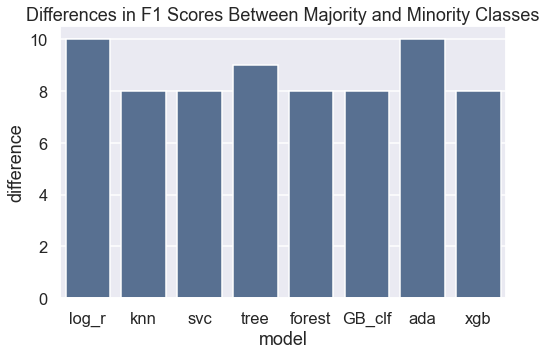

In [102]:
validation_f1['difference'] = (validation_f1['majority_class'] - 
                               validation_f1['minority_class'] )

plt.subplots(figsize=(8,5))
sns.barplot(data=validation_f1, x='clf', y='difference', color=NEUTRAL)
plt.title('Differences in F1 Scores Between Majority and Minority Classes')
plt.xlabel('model');

As discussed before, a balance is desired between precision and recall. Because of this, I will focus on the F1 scores on the validation set for each of the models.

All of the models also do a better job at predicting the minority class (will not cancel) than the majority one. Logistic regression, decision tree and Ada Boost were the worst in this aspect, based on the differences in the F1 scores between the majority and minority classes. 



The following models had high accuracy scores, high F1 scores and a smaller difference in F1 between the classes:
- Support Vector Classifier
- Random Forest
- XG Boost

I will tune each of these models to try to improve their performance further.

## Evaluating Features

### Preliminary Feature Importances From Random Forest

In [103]:
rf = clf_dict['forest']
rf.fit(X_train_smote, y_train_smote)
prelim_feature_importances = pd.DataFrame(list(
    zip(
        feature_names, 
        rf.feature_importances_))).sort_values(
    1, ascending=False)
prelim_feature_importances.columns = ['feature', 'importance']

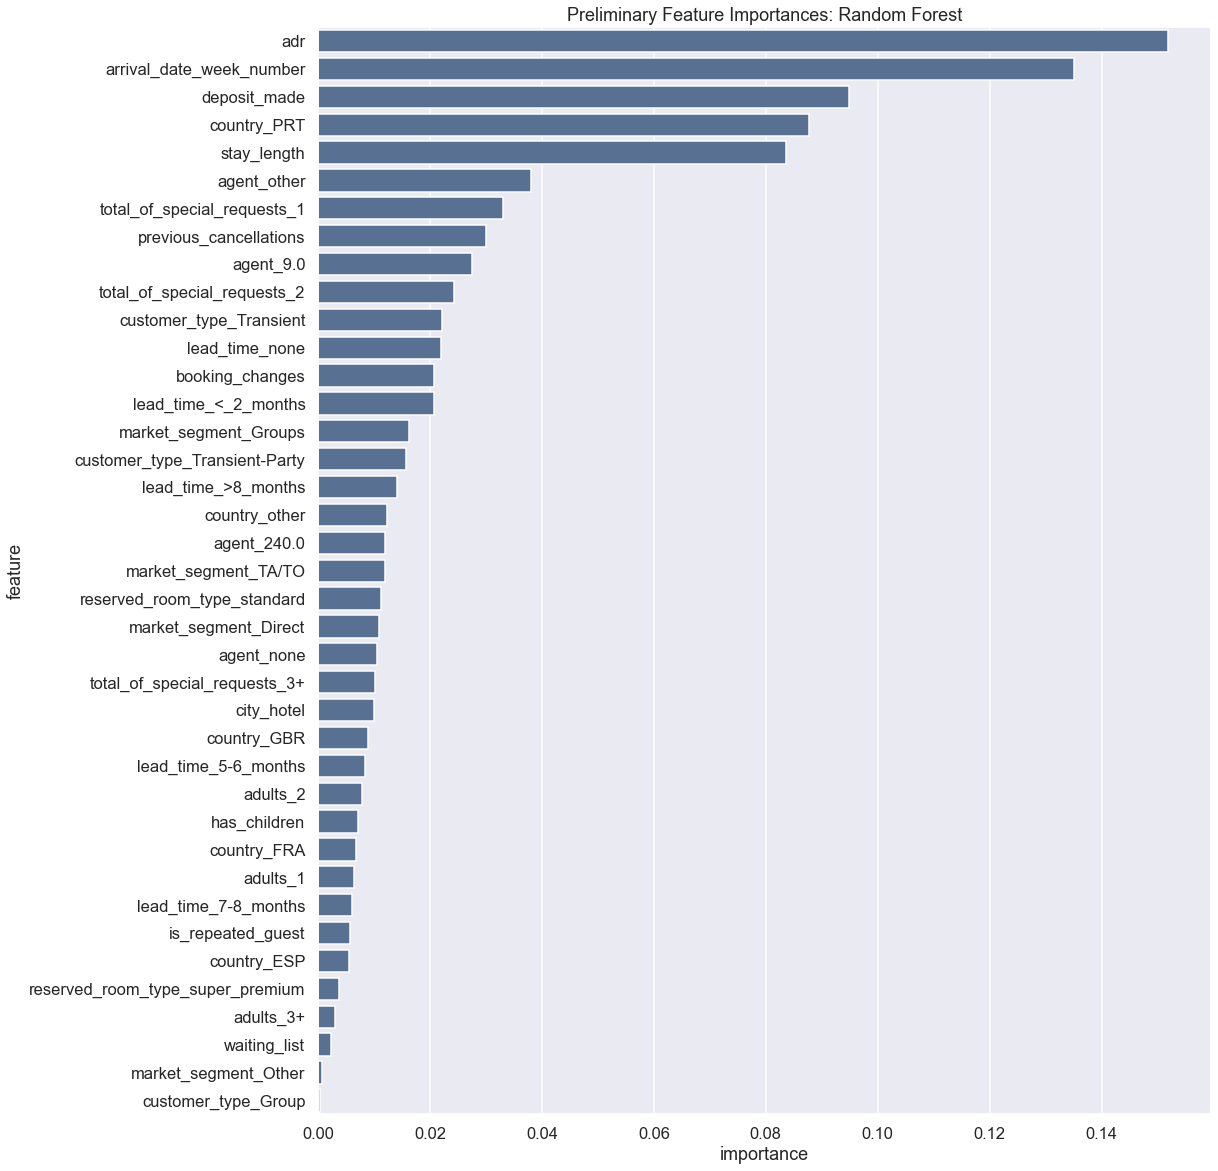

In [104]:
fig,ax = plt.subplots(figsize=(16,20))
sns.barplot(data=prelim_feature_importances, 
            x='importance',
            y='feature',
            color = NEUTRAL)
plt.title('Preliminary Feature Importances: Random Forest');

Based on the current Random Forest model, the following features are the most important:
- average daily rate (15%)
- arrival date week number (14%)
- deposit made (9%)
- country Portugal (9%)
- length of stay (8%)

The following features have little to no importance (less than 1%):
- country_GBR
- lead_time_5-6_months
- adults_2
- has_children
- country_FRA
- adults_1
- lead_time_7-8_months
- is_repeated_guest
- reserved_room_type_super_premium
- adults_3+
- waiting_list
- market_segment_Other
- customer_type_Group

### Preliminary Feature Importances From XGBoost

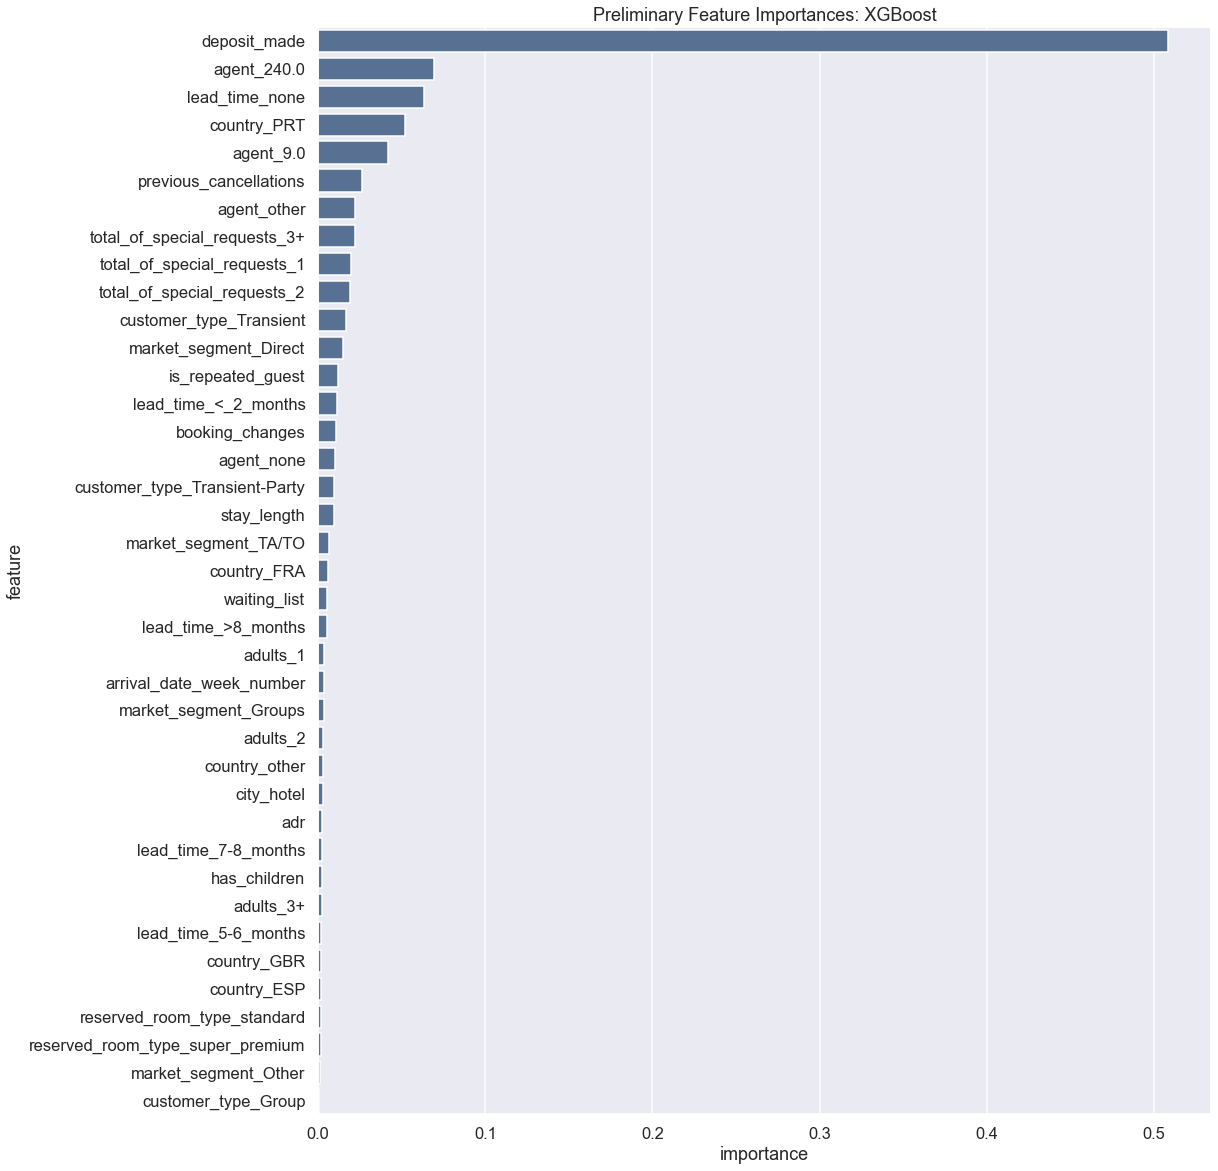

In [105]:
xg = clf_dict['xgb']
xg.fit(X_train_smote, y_train_smote)
prelim_feature_importances_xg = pd.DataFrame(list(
    zip(
        feature_names, 
        xg.feature_importances_))).sort_values(
    1, ascending=False)
prelim_feature_importances_xg.columns = ['feature', 'importance']
fig,ax = plt.subplots(figsize=(16,20))
sns.barplot(data=prelim_feature_importances_xg, 
            x='importance',
            y='feature',
            color = NEUTRAL)
plt.title('Preliminary Feature Importances: XGBoost');

According to XGBoost, the most important feature by far is the requirement of a deposit. Many of the least important features are also ranked in the bottom for random forest. These are features to consider dropping. 

### Removing Non-Important Features

In [106]:
X_train = X_train.copy()
X_val = X_val.copy()

features_to_drop = ['adults', 'is_repeated_guest','reserved_room_type', 
                    'waiting_list']
X_train_reduced = X_train.drop(features_to_drop, axis=1)

cat_cols_reduced = X_train_reduced.select_dtypes('object').columns
num_cols_reduced = X_train_reduced.select_dtypes('number').columns

transformer_reduced = ColumnTransformer([
    ('num', num_transformer, num_cols_reduced),
    ('cat', cat_transformer, cat_cols_reduced),
    ])

preprocess_reduced = Pipeline([('transformer', transformer_reduced)])

X_train_reduced_processed = preprocess_reduced.fit_transform(X_train_reduced)

X_val_reduced = X_val.drop(features_to_drop, axis=1)
X_val_reduced_processed = preprocess_reduced.transform(X_val_reduced)

cat_cols_reduced = X_train_reduced.select_dtypes('object').columns
num_cols_reduced = X_train_reduced.select_dtypes('number').columns


cat_names_reduced = (preprocess_reduced.named_steps['transformer']
             .transformers_[1][1].named_steps['ohe']
             .get_feature_names(cat_cols_reduced))
feature_names_reduced = list(num_cols_reduced) + list(cat_names_reduced)

i_1r = len(num_cols_reduced)+1
i_2r = len(feature_names_reduced)

oversampler_r = SMOTENC(categorical_features = list(range(i_1r,i_2r)), 
                      n_jobs=-2, 
                      random_state=SEED)

# X_train_reduced_smote, y_train_reduced_smote = oversampler_r.fit_resample(
    X_train_reduced_processed, y_train)


In [287]:
X_reduced_smote_file = 'X_reduced_smote.pk1'
# joblib.dump(X_train_reduced_smote, X_reduced_smote_file)
X_train_reduced_smote = joblib.load(X_reduced_smote_file)

y_reduced_smote_file = 'y_reduced_smote.pk1'
# joblib.dump(y_train_reduced_smote, y_reduced_smote_file)
y_reduced_train_smote = joblib.load(y_reduced_smote_file)


### Evaluating the Models After Feature Reduction

#### Support Vector Classifier

In [129]:
# svc_reduced_report = get_report('svc', 
#            clf_dict, 
#            X_train_reduced_smote, 
#            y_train_reduced_smote, 
#            X_val_reduced_processed, 
#            y_val)

svc_reduced_report_file = 'svc_reduced_report.pk1'
# joblib.dump(svc_reduced_report, svc_reduced_report_file)
svc_reduced_report = joblib.load(svc_reduced_report_file)

print('Original SVC Report')
print(svc_report)
print('\n\n')
print('SVC Reduced Features Report')
print(svc_reduced_report)

Original SVC Report
                      0            1  accuracy     macro avg  weighted avg
precision      0.886177     0.782385  0.846384      0.834281      0.847759
recall         0.867538     0.810387  0.846384      0.838962      0.846384
f1-score       0.876758     0.796140  0.846384      0.836449      0.846918
support    11173.000000  6566.000000  0.846384  17739.000000  17739.000000



SVC Reduced Features Report
                      0            1  accuracy     macro avg  weighted avg
precision      0.885457     0.775397  0.842889      0.830427      0.844719
recall         0.862078     0.810235  0.842889      0.836156      0.842889
f1-score       0.873611     0.792433  0.842889      0.833022      0.843564
support    11173.000000  6566.000000  0.842889  17739.000000  17739.000000


The SVC model did slightly worse with the feature reduction.

#### Random Forest

In [130]:
forest_reduced_report = get_report('forest', 
           clf_dict, 
           X_train_reduced_smote, 
           y_train_reduced_smote, 
           X_val_reduced_processed, 
           y_val)

print('Original Random Forest Report')
print(forest_report)
print('\n\n')
print('Random Forest Reduced Features Report')
print(forest_reduced_report)

Original Random Forest Report
                      0            1  accuracy     macro avg  weighted avg
precision      0.887891     0.817285  0.862055      0.852588      0.861757
recall         0.893851     0.807950  0.862055      0.850901      0.862055
f1-score       0.890861     0.812591  0.862055      0.851726      0.861890
support    11173.000000  6566.000000  0.862055  17739.000000  17739.000000



Random Forest Reduced Features Report
                      0            1  accuracy     macro avg  weighted avg
precision      0.890605     0.809690  0.860477      0.850147      0.860655
recall         0.887497     0.814499  0.860477      0.850998      0.860477
f1-score       0.889048     0.812087  0.860477      0.850568      0.860562
support    11173.000000  6566.000000  0.860477  17739.000000  17739.000000


The Random Forest model did slightly worse with the feature reduction.

#### XGBoost

In [131]:
xgb_reduced_report = get_report('xgb', 
           clf_dict, 
           X_train_reduced_smote, 
           y_train_reduced_smote, 
           X_val_reduced_processed, 
           y_val)

print('Original XGBoost Report')
print(xgb_report)
print('\n\n')
print('XGBoost Reduced Features Report')
print(xgb_reduced_report)

Original XGBoost Report
                      0            1  accuracy     macro avg  weighted avg
precision      0.885094     0.812009  0.858335      0.848552      0.858042
recall         0.890719     0.803229  0.858335      0.846974      0.858335
f1-score       0.887898     0.807595  0.858335      0.847746      0.858174
support    11173.000000  6566.000000  0.858335  17739.000000  17739.000000



XGBoost Reduced Features Report
                      0            1  accuracy     macro avg  weighted avg
precision      0.887144     0.811792  0.859406      0.849468      0.859253
recall         0.890003     0.807341  0.859406      0.848672      0.859406
f1-score       0.888571     0.809560  0.859406      0.849066      0.859326
support    11173.000000  6566.000000  0.859406  17739.000000  17739.000000


The XGBoost model performed slightly better with the feature reduction.

Since the SCV and Random Forest models did worse with the reduced features, I will keep the original features when tuning those meodels. For XGBoost, I will use the reduced features, since that ;ed to a slight increase in performance. 

## Model Tuning

In [283]:
hyperparameter_dict = {
    'forest': [{
        'bootstrap': [True, False],
        'max_depth': [3,10, None],
        'max_features': [3, 'sqrt', 15],
        'n_estimators': [100, 1000, 2000],
    }],
    'svc': [{
        'C': [0.1, 1, 10, 100], 
        'gamma': [1, 0.1, 0.01, 0.001],
        'kernel': ['linear','rbf']
    }],
    'xgb': [{
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 10, None]
    }]
}


def tune_model(clf, clf_dict, hyperparameter_dict, scoring, X,y):
    """Takes in the model's key from the clf dictionary, a classifier
    dictionary, a hyperparameter dictionary, a scoring dictionary and and X 
    and y. A gridsearch is then performed using the 
    specified classifier and its associated hyperparameters from the
    hyperparameter dictonary. After the model is fitted, a
    GridSearchCV object is then returned."""
    
    if clf == 'svc':
        
        model = RandomizedSearchCV(clf_dict[clf],
                         hyperparameter_dict[clf], 
                         cv=3,
                         scoring = scoring,
                         refit = 'F1',
                         return_train_score=True,
                         n_jobs=-2,
                         error_score="raise",
                         random_state=SEED)
    
    else:
        model = GridSearchCV(clf_dict[clf],
                         hyperparameter_dict[clf], 
                         cv=3,
                         scoring = scoring,
                         refit = 'F1',
                         return_train_score=True,
                         n_jobs=-2,
                         error_score="raise")
    model.fit(X,y)
    
    return model

model_compare = {}

def score_model(model, clf):
    """Takes in a model and its key from the clf dictionary and returns
    a dictionary with its scoring metrics. It also appends this dictionary
    to the model_compare dictionary."""
    
    model_eval_dict = {}
    
    model_eval_dict['train_accuracy'] = (
        model.cv_results_['mean_train_Accuracy']).mean()
    model_eval_dict['test_accuracy'] = (
        model.cv_results_['mean_test_Accuracy']).mean()
    
    model_eval_dict['AUC_train'] = (
        model.cv_results_['mean_train_AUC']).mean()
    model_eval_dict['AUC_test'] = (
        model.cv_results_['mean_test_AUC']).mean()
    
    model_eval_dict['train_f1'] = (
        model.cv_results_['mean_train_F1']).mean()
    model_eval_dict['test_f1'] = (
        model.cv_results_['mean_test_F1']).mean()
    
    model_eval_dict['train_recall'] = (
        model.cv_results_['mean_train_Recall']).mean()
    model_eval_dict['test_recall'] = (
        model.cv_results_['mean_test_Recall']).mean()
    
    model_eval_dict['train_precision'] = (
        model.cv_results_['mean_train_Precision']).mean()
    model_eval_dict['test_precision'] = (
        model.cv_results_['mean_test_Precision']).mean()
    
    
    model_eval_dict['best_params'] = model.best_params_
    
    
    for k,v in model_eval_dict.items():
        print(f"{k}: {v}")
    
    model_compare[clf] = model_eval_dict

    
    return model_compare
    

### SVC

In [284]:
# scv_grid = tune_model('svc', clf_dict, hyperparameter_dict, scoring, X_train_smote,y_train_smote)

KeyboardInterrupt: 

In [ ]:
svc_grid_file = 'svc_grid.pk1'
joblib.dump(svc_grid, svc_grid_file)
svc_grid = joblib.load(svc_grid_file)   

### Random Forest

In [137]:
# forest_grid = tune_model('forest', clf_dict, hyperparameter_dict, scoring, X_train_smote,y_train_smote)

In [138]:
forest_grid_file = 'forest_grid.pk1'
# joblib.dump(forest_grid, forest_grid_file)
forest_grid = joblib.load(forest_grid_file)

In [140]:
score_model(forest_grid, 'forest')

train_accuracy: 0.8622679378678311
test_accuracy: 0.820618663184784
AUC_train: 0.9370434335123202
AUC_test: 0.9189524036751968
train_f1: 0.8459814621008036
test_f1: 0.803512878185212
train_recall: 0.8092973658753785
test_recall: 0.7651158601272506
train_precision: 0.902328373331738
test_precision: 0.8626790215477977
best_params: {'bootstrap': True, 'max_depth': None, 'max_features': 15, 'n_estimators': 2000}


{'forest': {'train_accuracy': 0.8622679378678311,
  'test_accuracy': 0.820618663184784,
  'AUC_train': 0.9370434335123202,
  'AUC_test': 0.9189524036751968,
  'train_f1': 0.8459814621008036,
  'test_f1': 0.803512878185212,
  'train_recall': 0.8092973658753785,
  'test_recall': 0.7651158601272506,
  'train_precision': 0.902328373331738,
  'test_precision': 0.8626790215477977,
  'best_params': {'bootstrap': True,
   'max_depth': None,
   'max_features': 15,
   'n_estimators': 2000}}}

In [172]:
print('Original Cross Validation')
screen_dict['forest']

Original Cross Validation


{'fit_time mean': 9.967270469665527,
 'fit_time std': 0.7274716752366345,
 'score_time mean': 0.5176458358764648,
 'score_time std': 0.15784529937552083,
 'test_AUC mean': 0.9584307053265734,
 'test_AUC std': 0.015376882278911487,
 'train_AUC mean': 0.9994991265971589,
 'train_AUC std': 6.044365736347167e-05,
 'test_Accuracy mean': 0.8852208704098485,
 'test_Accuracy std': 0.025332694208969782,
 'train_Accuracy mean': 0.9931816925392007,
 'train_Accuracy std': 0.0008789518277470821,
 'test_Recall mean': 0.8825078360011404,
 'test_Recall std': 0.06041766472933108,
 'train_Recall mean': 0.9932584097608752,
 'train_Recall std': 0.0008154303429316399,
 'test_Precision mean': 0.8874583514353123,
 'test_Precision std': 0.0026576555263816753,
 'train_Precision mean': 0.9931062042809993,
 'train_Precision std': 0.0009592632132041132,
 'test_F1 mean': 0.8838868379058524,
 'test_F1 std': 0.029066809313552894,
 'train_F1 mean': 0.9931822799782303,
 'train_F1 std': 0.0008783564760839715}

In [162]:
forest_best = forest_grid.best_estimator_

y_pred_forest = forest_best.predict(X_val_processed)

print(classification_report(y_val, y_pred_forest))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89     11173
           1       0.82      0.82      0.82      6566

    accuracy                           0.87     17739
   macro avg       0.86      0.86      0.86     17739
weighted avg       0.87      0.87      0.87     17739



In [171]:
print('Original report')
forest_report

Original report


,0,1,accuracy,macro avg,weighted avg
precision,0.887891,0.817285,0.862055,0.852588,0.861757
recall,0.893851,0.807950,0.862055,0.850901,0.862055
f1-score,0.890861,0.812591,0.862055,0.851726,0.861890
support,11173.000000,6566.000000,0.862055,17739.000000,17739.000000


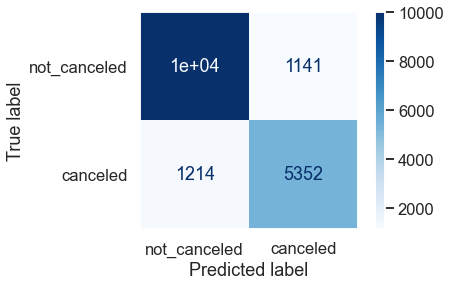

In [173]:
best_forest_matrix = plot_confusion_matrix(forest_best, 
                      X_val_processed, 
                      y_val,
                      display_labels=CLASS_NAMES,
                      cmap=plt.cm.Blues)
plt.grid(None)

best_forest_matrix

Overfitting has been reduced, although it is still an issue. Training additional estimators may help with this. The accuracy on the test folds decreased during cross validation, but the accuracy increased on the validation set. Based on the standard deviation of the accuracy results in the original cross validation, there is some variability in the results, so the increase in the validation set may be due to random chance. Recall and F1 increased slightly for the minority class and precision and recall are balanced. 

### XGBoost

In [187]:
# xgb_grid = tune_model('xgb', clf_dict, hyperparameter_dict, scoring, X_train_reduced_smote,y_train_reduced_smote)

In [188]:
xgb_grid_file = 'xgb_grid.pk1'
# joblib.dump(xgb_grid, xgb_grid_file)
xgb_grid = joblib.load(xgb_grid_file)

In [189]:
score_model(xgb_grid, 'xgb')

train_accuracy: 0.8873107591350146
test_accuracy: 0.8571183153924703
AUC_train: 0.9594903579327656
AUC_test: 0.9427158194351407
train_f1: 0.886704791277522
test_f1: 0.8532436018303252
train_recall: 0.8814808708509311
test_recall: 0.8390829973257048
train_precision: 0.8920275735077136
test_precision: 0.8716434520388748
best_params: {'colsample_bytree': 1.0, 'gamma': 1, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 1.0}


{'forest': {'train_accuracy': 0.8622679378678311,
  'test_accuracy': 0.820618663184784,
  'AUC_train': 0.9370434335123202,
  'AUC_test': 0.9189524036751968,
  'train_f1': 0.8459814621008036,
  'test_f1': 0.803512878185212,
  'train_recall': 0.8092973658753785,
  'test_recall': 0.7651158601272506,
  'train_precision': 0.902328373331738,
  'test_precision': 0.8626790215477977,
  'best_params': {'bootstrap': True,
   'max_depth': None,
   'max_features': 15,
   'n_estimators': 2000}},
 'xgb': {'train_accuracy': 0.8873107591350146,
  'test_accuracy': 0.8571183153924703,
  'AUC_train': 0.9594903579327656,
  'AUC_test': 0.9427158194351407,
  'train_f1': 0.886704791277522,
  'test_f1': 0.8532436018303252,
  'train_recall': 0.8814808708509311,
  'test_recall': 0.8390829973257048,
  'train_precision': 0.8920275735077136,
  'test_precision': 0.8716434520388748,
  'best_params': {'colsample_bytree': 1.0,
   'gamma': 1,
   'max_depth': 10,
   'min_child_weight': 1,
   'subsample': 1.0}}}

In [192]:
print('Original Cross Validation')
screen_dict['xgb']

Original Cross Validation


{'fit_time mean': 23.33214259147644,
 'fit_time std': 0.19841177196886214,
 'score_time mean': 0.2792414665222168,
 'score_time std': 0.0067058127193817055,
 'test_AUC mean': 0.9536040128283654,
 'test_AUC std': 0.022661179368304845,
 'train_AUC mean': 0.9660972892648776,
 'train_AUC std': 0.005588502560960043,
 'test_Accuracy mean': 0.8722653374897472,
 'test_Accuracy std': 0.03479161686443435,
 'train_Accuracy mean': 0.8943234047775055,
 'train_Accuracy std': 0.009813042543487532,
 'test_Recall mean': 0.8587832446737578,
 'test_Recall std': 0.08219462169576272,
 'train_Recall mean': 0.8873971930459778,
 'train_Recall std': 0.007406508165600999,
 'test_Precision mean': 0.8827281439407269,
 'test_Precision std': 0.0020015191085289022,
 'train_Precision mean': 0.8999209785613814,
 'train_Precision std': 0.011891078273274815,
 'test_F1 mean': 0.868558454406771,
 'test_F1 std': 0.04082734817194011,
 'train_F1 mean': 0.8936097383328286,
 'train_F1 std': 0.00961292700435676}

In [193]:
xgb_best = xgb_grid.best_estimator_
y_pred_xgb = xgb_best.predict(X_val_reduced_processed)

print(classification_report(y_val, y_pred_forest))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89     11173
           1       0.82      0.82      0.82      6566

    accuracy                           0.87     17739
   macro avg       0.86      0.86      0.86     17739
weighted avg       0.87      0.87      0.87     17739



In [194]:
print('Original report')
xgb_report

Original report


,0,1,accuracy,macro avg,weighted avg
precision,0.885094,0.812009,0.858335,0.848552,0.858042
recall,0.890719,0.803229,0.858335,0.846974,0.858335
f1-score,0.887898,0.807595,0.858335,0.847746,0.858174
support,11173.000000,6566.000000,0.858335,17739.000000,17739.000000


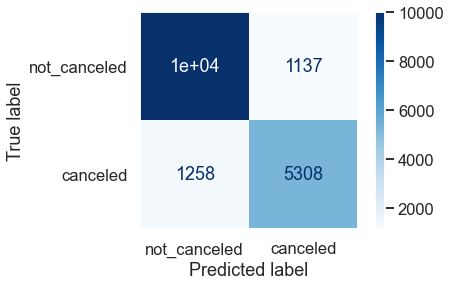

In [195]:
best_xgb_matrix = plot_confusion_matrix(xgb_best, 
                      X_val_reduced_processed, 
                      y_val,
                      display_labels=CLASS_NAMES,
                      cmap=plt.cm.Blues)
plt.grid(None)

best_forest_matrix

There is still overfitting, with the biggest impact seen in recall and overall accuracy. Overall, the metrics improved slightly and are quite similar to the results from the random forest classifier.

## Final Model Selection and Evaluation

# Data Summarization and Visualization

(0.9851323828920571,
 No Deposit    0.671445
 Non Refund    0.327741
 Refundable    0.000814
 Name: deposit_type, dtype: float64)

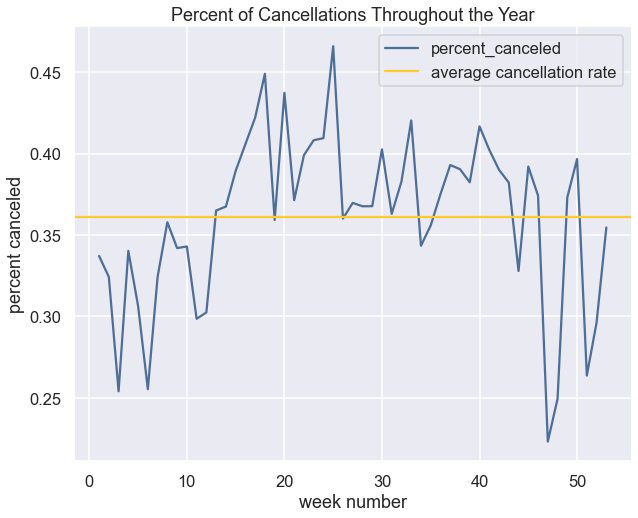

In [197]:
hotels_final = hotels.copy()

#Change date string to datetime object.
hotels_final['reservation_status_date'] = pd.to_datetime(
    hotels_final['reservation_status_date'])

#Add weekends and weeknights together to get total stay length.
hotels_final['stay_length'] = (
    hotels_final['stays_in_weekend_nights'] +
    hotels_final['stays_in_week_nights']
)

#Add a column to show the date the reservation was made by using the status
#date, the lead time and the length of stay. 
hotels_final['booking_date'] = (hotels_final['reservation_status_date'] +
                               pd.to_timedelta(hotels_final['lead_time'], 
                                               unit='d') - 
                               pd.to_timedelta(hotels_final['stay_length'], 
                                               unit='d'))

#Create a dataframe of only customers who canceled.
canceled = hotels_final.copy()
canceled = canceled[hotels_final['is_canceled']==1]

#Create a dataframe of only customers who did not cancel.
not_canceled = hotels_final.copy()
not_canceled = not_canceled[hotels_final['is_canceled']==0]


#Percent of reservations canceled by week. 
hotels_final['constant'] = 1
by_week = hotels_final.groupby('arrival_date_week_number').sum()
by_week['percent_canceled'] = by_week['is_canceled']/by_week['constant']
fig,ax = plt.subplots(figsize=(10,8))
by_week['percent_canceled'].plot(color=NEUTRAL)
plt.ylabel('percent canceled')
plt.xlabel('week number')
plt.title('Percent of Cancellations Throughout the Year')
plt.axhline(by_week['percent_canceled'].mean(), 
            color=NEG, 
            label='average cancellation rate')
plt.legend();

#Average daily rates
canceled_mean_adr = canceled['adr'].mean()
not_canceled_mean_adr = not_canceled['adr'].mean()


#Deposit types
canceled_deposits = canceled['deposit_type'].value_counts(normalize=True)
not_canceled_deposits = not_canceled['deposit_type'].value_counts(normalize=True)

deposits_overall = hotels_final['deposit_type'].value_counts(normalize=True)

deposit_canceled = hotels_engineered[((hotels_engineered['deposit_made']==1)&
                   (hotels_engineered['is_canceled']==1))].shape[0]

deposit = hotels_engineered[(hotels_engineered['deposit_made']==1)].shape[0]

percent_deposit_canceled = deposit_canceled/deposit
percent_deposit_canceled, canceled_deposits

<AxesSubplot:xlabel='arrival_date_week_number'>

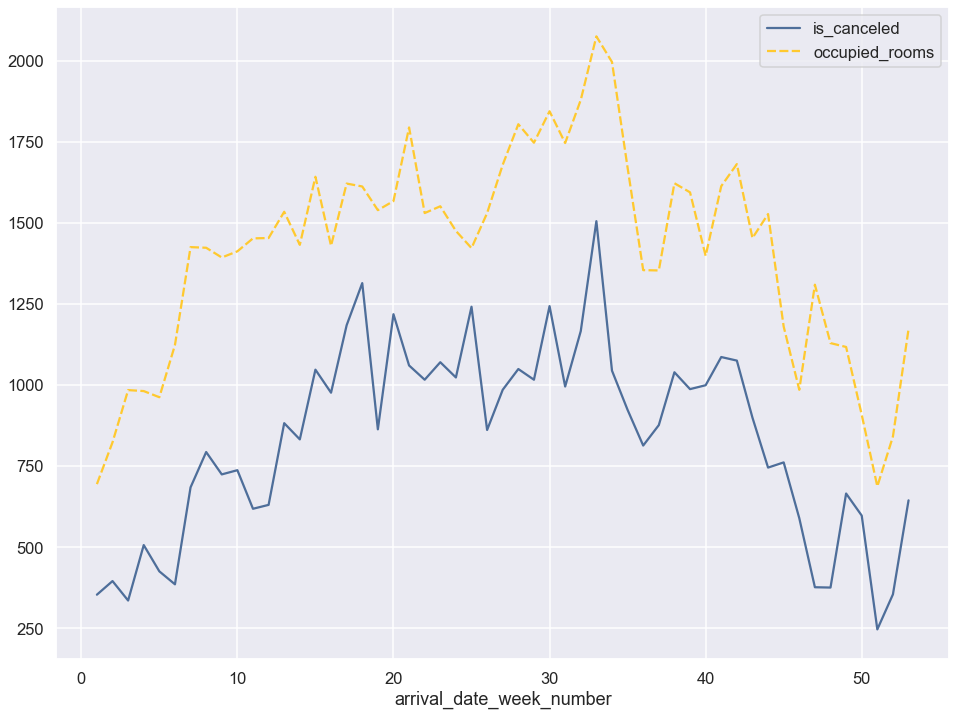

In [225]:
activity_by_week = by_week.copy()
activity_by_week['occupied_rooms'] = activity_by_week['constant'] - activity_by_week['is_canceled']
activity_by_week = activity_by_week[['is_canceled', 'occupied_rooms']]
fig, ax = plt.subplots(figsize=(16,12))
sns.lineplot(data=activity_by_week)

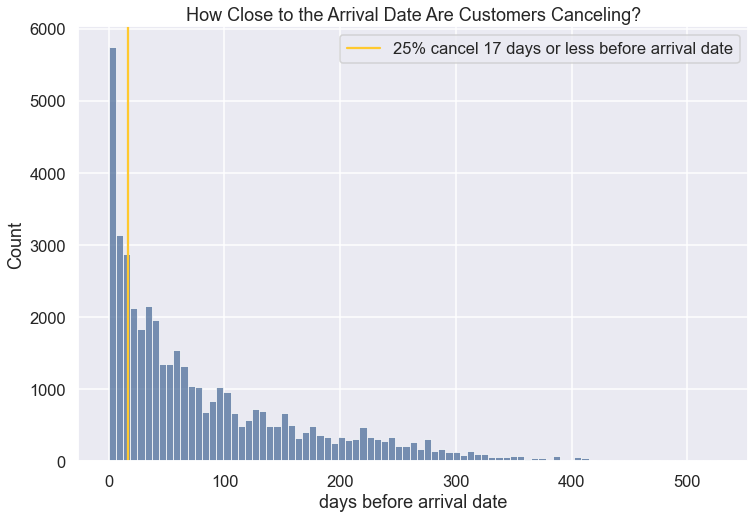

In [223]:
#Add a column to show how long before their predicted arrival date they made
#the cancellation.
canceled['canceled_days_before_arrival'] = (canceled['arrival_date'] - 
                                    canceled['reservation_status_date'])

canceled_days_before = (canceled['canceled_days_before_arrival'].
                        apply(lambda x: x/np.timedelta64(1, 'D')))
plt.subplots(figsize=(12,8))
sns.histplot(data=canceled_days_before)
plt.axvline(canceled_days_before.quantile(0.25), 
            color=NEG, 
            label='25% cancel 17 days or less before arrival date')
plt.legend()
plt.xlabel('days before arrival date')
plt.title('How Close to the Arrival Date Are Customers Canceling?')
plt.xlim([0,400]);

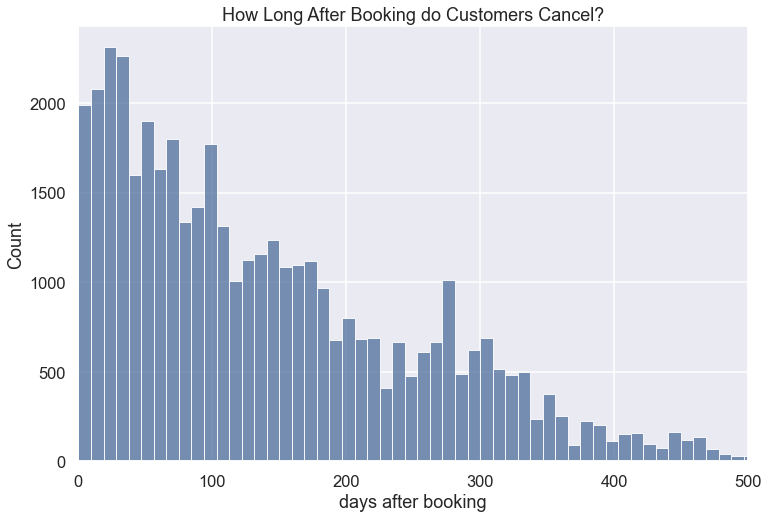

In [234]:
#Add a column to show the number of days between making and cancelling the
#reservation.
canceled['canceled_days_after_reservation'] = (canceled['booking_date'] - 
                                    canceled['reservation_status_date'])

canceled_days_after = (canceled['canceled_days_after_reservation'].
                        apply(lambda x: x/np.timedelta64(1, 'D')))

plt.subplots(figsize=(12,8))
sns.histplot(data=canceled_days_after)
plt.xlabel('days after booking')
plt.xlim([0,500])
plt.title('How Long After Booking do Customers Cancel?');

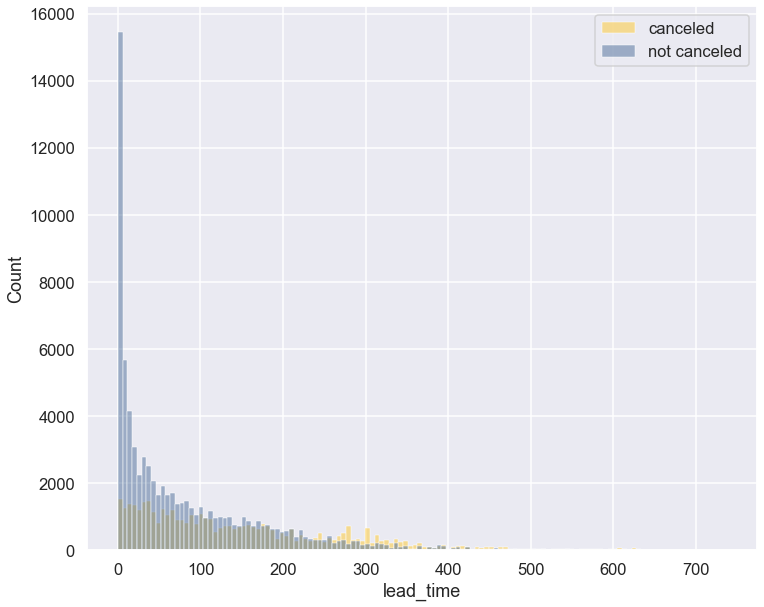

In [241]:
plt.subplots(figsize=(12,10))
sns.histplot(data=hotels_final, x='lead_time', hue='is_canceled', color=COLORS)
plt.legend(labels=['canceled', 'not canceled'])
plt.xlim([0,500])
plt.title('How Does Lead Time Relate to Cancellations?')

In [ ]:
plt.subplots(figsize=(12,10))
sns.histplot(data=hotels_final, x='lead_time', hue='is_canceled', color=COLORS)
plt.legend(labels=['canceled', 'not canceled'])
plt.xlim([0,500])
plt.ylim([0,2000])
plt.title('How Does Lead Time Relate to Cancellations?')

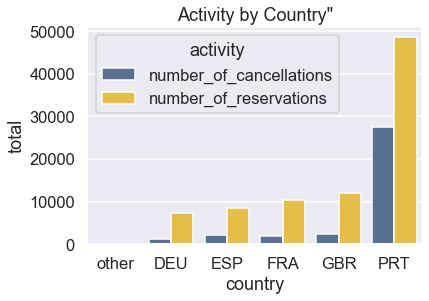

In [277]:
by_country = hotels_final.groupby('country').sum().reset_index()
by_country['country'] = by_country['country'].apply(country_group)
by_country['number_of_stays'] - by_country['constant'] - by_country['is_cancelled']
by_country['percent_canceled'] = (by_country['is_canceled']/
                                  by_country['constant'])
by_country['percent_of_reservations'] = by_country['constant']/hotels_final.shape[0]
by_country = by_country[['country','is_canceled','constant']]
by_country.columns = ['country','number_of_reservations', 'number_of_cancellations', 'number_of_stays']
df = pd.melt(by_country, 
             id_vars='country', 
             var_name='activity', 
             value_name='total')
sns.barplot(data=df, x='country', y='total', hue='activity', ci=None)
plt.title('Activity by Country');

# Conclusions and Recommendations

## How Cancellations Impact Profit

how many days reserved before cancellation? how many days between cancellation and reservation date? cancellations over time of year? patterns in waiitng list

## Identifying Customers Likely to Cancel

avg room rate canceled vs not
% canceled deposit vs percent not canceled deposit
avg len of stay of those who canceled vs not
% canceled Portugal, France, etc
percent canceled by week of arrival

## Understanding When Cancellations Occur

how long between date reservation made, date cancelation occured, date expected arrival?
multiple line graph x=booking date, y=number bookings made, number arrivals, number cancellations

## What Can Be Done to Reduce the Impact of Cancellations

which customers book last-minute? market to them
expand deposits
consider overbooking rooms (what %?) when cancellations are generally highest (week number)
limit booking too far in advance or send confirmation emails, require deposits for advanced bookings
promote waiting lists


# Future Work

data on number of empty rooms each night
A/B testing on different deposit strategies
correlate with city/regional event calendars
covid impact on cancellations